In [73]:
import pandas as pd
import os
import seaborn as sb
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn as sk

# Load Data

In [74]:
client_df = pd.read_csv('./ficheiros_competicao_dev/client.csv', sep=';', low_memory=False)

account_df = pd.read_csv('./ficheiros_competicao_dev/account.csv', sep=';', low_memory=False)

trans_dev_df = pd.read_csv('./ficheiros_competicao_dev/trans_dev.csv', sep=';', low_memory=False)

loan_dev_df = pd.read_csv('./ficheiros_competicao_dev/loan_dev.csv', sep=';', low_memory=False)

card_dev_df = pd.read_csv('./ficheiros_competicao_dev/card_dev.csv', sep=';', low_memory=False)

disp_df = pd.read_csv('./ficheiros_competicao_dev/disp.csv', sep=';', low_memory=False)

district_df = pd.read_csv('./ficheiros_competicao_dev/district.csv', sep=';', low_memory=False, na_values='?')

# Domain Analysis

## Business Understanding

### End User Requirements

The end user requires a system to determine which clients are and are not capable of paying of the loans they seek to make of the end user.

### Business Goals

In this problem the positive case is a client that cannot pay a loan. The business goal is to create a system to:
- Reduce the amount of loan attributions to clients who will default on the loan
- Mantain the amount of loan attributions to clients who can fulfill the loan

### Data Mining Goals

From the business goals we can determine that the goal of the model is to avoid granting a loan to a client who cannot pay it back, minimize false negatives so we must optimze for recall.

## Data Understanding

In [75]:
print("account", account_df.describe(include='all'), "\n")
print("client", client_df.describe(include='all'), "\n")
print("disposition", disp_df.describe(include='all'), "\n")
print("district", district_df.describe(include='all'), "\n")
print("card_train", card_dev_df.describe(include='all'), "\n")
print("loan_train", loan_dev_df.describe(include='all'), "\n")
print("trans_train", trans_dev_df.describe(include='all'), "\n")

account           account_id  district_id         frequency           date
count    4500.000000  4500.000000              4500    4500.000000
unique           NaN          NaN                 3            NaN
top              NaN          NaN  monthly issuance            NaN
freq             NaN          NaN              4167            NaN
mean     2786.067556    37.310444               NaN  951654.608667
std      2313.811984    25.177217               NaN   14842.188377
min         1.000000     1.000000               NaN  930101.000000
25%      1182.750000    13.000000               NaN  931227.000000
50%      2368.000000    38.000000               NaN  960102.000000
75%      3552.250000    60.000000               NaN  961101.000000
max     11382.000000    77.000000               NaN  971229.000000 

client           client_id   birth_number  district_id
count   5369.000000    5369.000000  5369.000000
mean    3359.011920  535114.970013    37.310114
std     2832.911984  172895.618429 

### Loans

In [76]:
len(loan_dev_df[loan_dev_df['status'] == 1]) / len(loan_dev_df) * 100

85.97560975609755

Around 86% of loans in the dataset have been payed off, so accuracy is not the best measure to optimize for.

<BarContainer object of 2 artists>

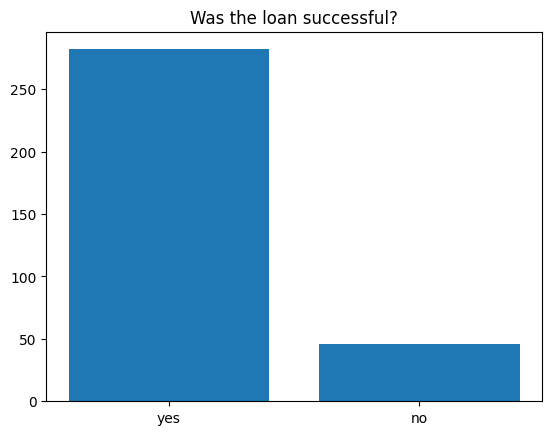

In [77]:
status_values = loan_dev_df["status"].value_counts()
plt.title("Was the loan successful?")
plt.bar(["yes", "no"], status_values)

This bar plot shows the number of loans given and the number of loans not given side by side. From this graph, you can understand that, for most cases, the loan was given. Therefore, this can be considered and unbalanced dataset, making it harder to predict when loans are not given.

<AxesSubplot:xlabel='status', ylabel='amount'>

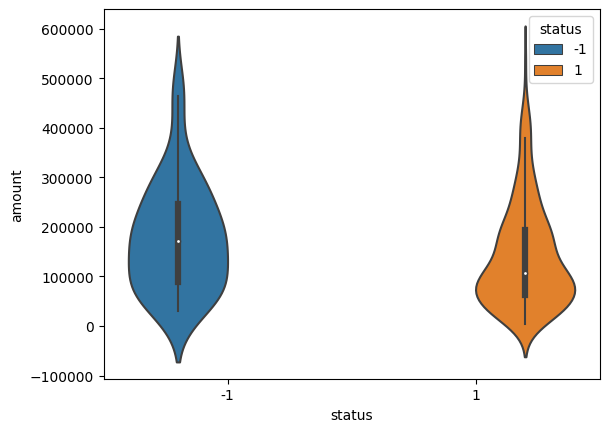

In [78]:
sb.violinplot(x='status', y='amount', data=loan_dev_df, hue='status')

We can see a larger amount of the loans over 100,000 are not payed off.

# Data Treatment

## Whitespace Removal

In [79]:
district_df.rename(columns=lambda x: x.strip(), inplace=True)

## Missing Values

### Acount

In [80]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No missing values on **account_df**

### Client

In [81]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

No missing values on **client_df**

### Loans

In [82]:
loan_dev_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

No missing values on **loan_dev_df**

### Transactions

In [83]:
trans_dev_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

There are missing values on **trans_dev_df**

#### Operation

In [84]:
trans_dev_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [85]:
len(trans_dev_df[trans_dev_df['operation'].isnull()]) / len(trans_dev_df['operation']) * 100

17.838083113805663

There is a significant number of null values in the operations column. These will be replaced by 'N/A'.

In [86]:
trans_dev_df['operation'].fillna('N/A', inplace=True)

In [87]:
trans_dev_df['operation'].value_counts()

withdrawal in cash              165270
N/A                              70761
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

#### K Symbol

In [88]:
trans_dev_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There are many empty string values. It is assumed these mean the transaction type wasn't registered and they will be treated the same as null values.

In [89]:
def remove_empty_values_k_symbol(k):
    if isinstance(k, float):
        return'N/A'
    elif isinstance(k, str) and k.strip() == '':
        return 'N/A'
    else:
        return k

trans_dev_df['k_symbol'] = trans_dev_df['k_symbol'].apply(remove_empty_values_k_symbol)

trans_dev_df['k_symbol'].value_counts()

N/A                                      204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

#### Bank

In [90]:
trans_dev_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

There aren't any empty strings. Null values will be replaced by unknown.

In [91]:
trans_dev_df['bank'].fillna('Unknown', inplace=True)

In [92]:
trans_dev_df['bank'].value_counts()

Unknown    299443
ST           8114
GH           7886
EF           7878
AB           7666
UV           7618
OP           7595
IJ           7536
YZ           7471
QR           7413
KL           7397
WX           7033
CD           7009
MN           6626
Name: bank, dtype: int64

#### Account

In [93]:
trans_dev_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

There are many transactions to an account **0**. This will be treated as a transaction to an unknown account.

In [94]:
trans_dev_df['account'].fillna(0, inplace=True)

In [95]:
trans_dev_df['account'].value_counts()

0.0           299443
30300313.0        48
37906074.0        48
45134812.0        48
15916598.0        48
               ...  
99218499.0         1
54261672.0         1
28306174.0         1
91523855.0         1
53761804.0         1
Name: account, Length: 4536, dtype: int64

### Cards

In [96]:
card_dev_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

There are no missing values in **card_dev_df**

### Disposition

In [97]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

There are no missing values in **disp_df**

### District

In [98]:
district_df.isnull().sum()

code                                                0
name                                                0
region                                              0
no. of inhabitants                                  0
no. of municipalities with inhabitants < 499        0
no. of municipalities with inhabitants 500-1999     0
no. of municipalities with inhabitants 2000-9999    0
no. of municipalities with inhabitants >10000       0
no. of cities                                       0
ratio of urban inhabitants                          0
average salary                                      0
unemploymant rate '95                               1
unemploymant rate '96                               0
no. of enterpreneurs per 1000 inhabitants           0
no. of commited crimes '95                          1
no. of commited crimes '96                          0
dtype: int64

There are missing values in **district_df**

In [99]:
district_df[district_df['unemploymant rate \'95'].isnull()]

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,NaN,7.01,124,NaN,1358


Both null values com from the district of Jesenik.

We will replace the null values by finding the mean values for the region in 1995 and 1996 and inferring the 1995 values for Jesenik from the 1996 values.

In [100]:
unemp_rate_96_mean = district_df[district_df['region'] == 'north Moravia']['unemploymant rate \'96'].median()

unemp_rate_95_mean = district_df[district_df['region'] == 'north Moravia']['unemploymant rate \'95'].median()

unemp_rate_96_jes = district_df.iloc[68]['unemploymant rate \'96']

predicted_unemp_rate_95_jes = (unemp_rate_95_mean/unemp_rate_96_mean) * unemp_rate_96_jes

district_df['unemploymant rate \'95'].fillna(predicted_unemp_rate_95_jes, inplace=True)

crimes_96_mean = district_df[district_df['region'] == 'north Moravia']['no. of commited crimes \'96'].median()

crimes_95_mean = district_df[district_df['region'] == 'north Moravia']['no. of commited crimes \'95'].median()

crimes_96_jes = district_df.iloc[68]['no. of commited crimes \'96']

predicted_crimes_95_jes = (crimes_95_mean/crimes_96_mean) * crimes_96_jes

district_df['no. of commited crimes \'95'].fillna(predicted_crimes_95_jes, inplace=True)

## Date Functions

In [101]:
# Format birth number to date (DD-MM-YY) <- may need to change formatting for algorithms
def get_formatted_date(date_number):
    date_number_string = str(date_number)
    return date_number_string[4:6] + '/' + str(int(date_number_string[2:4]) % 50) + '/' + '19' + date_number_string[0:2]

# Get client sex from birth number (MM > 50 => sex == 'F')
def get_client_sex_from_birth_number(date_number):
    return 'F' if int(str(date_number)[2:4]) >= 51 else 'M'

# Get the season from a date
def get_season_from_Date(date_string):
    date_string_str = str(date_string)
    day = int(date_string_str[8:10])
    month = int(date_string_str[5:7])
    year = int(date_string_str[0:4])

    winterStart = datetime.datetime(year, 12, 22)
    springStart = datetime.datetime(year, 3, 20)
    summerStart = datetime.datetime(year, 6, 21)
    autumnStart = datetime.datetime(year, 9, 22)

    if ((month <= 3 and day <= 20) or (month >= 12 and day > 22)):
        return "winter"
    elif (date_string < summerStart):
        return "spring"
    elif (date_string < autumnStart) : 
        return "summer"
    elif (date_string < winterStart) :
        return "autumn"

    return "FAILEDSEASON"

# Get the year from a date
def get_year_from_date(date_string):
    date_string_str = str(date_string)
    year = int(date_string_str[0:4])

    return year

## Format dates and determine client sex

In [102]:
# Format client birthday and determine sex

client_df['birthday'] = pd.to_datetime(client_df['birth_number'].apply(get_formatted_date), infer_datetime_format=True)

client_df['sex'] = client_df['birth_number'].apply(get_client_sex_from_birth_number)

client_df = client_df.drop(columns=['birth_number'])

# Format other dates

account_df['acc_creation_date'] = pd.to_datetime(account_df['date'].apply(get_formatted_date), infer_datetime_format=True)

account_df = account_df.drop(columns=['date'])

trans_dev_df['trans_date'] = pd.to_datetime(trans_dev_df['date'].apply(get_formatted_date), infer_datetime_format=True)

trans_dev_df = trans_dev_df.drop(columns=['date'])

loan_dev_df['date'] = pd.to_datetime(loan_dev_df['date'].apply(get_formatted_date), infer_datetime_format=True)

card_dev_df['issued'] = pd.to_datetime(card_dev_df['issued'].apply(get_formatted_date), infer_datetime_format=True)

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '14/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '15/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '16/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '17/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppDa

# Join Data

Data must all be displayed in one dataset.

## Join Account and Disposition

In [103]:
joined_df = account_df.merge(disp_df, on='account_id', how='inner', suffixes=['', '_disp'])

joined_df.rename(columns={
    'type': 'account_type',
    'frequency': 'issuance_freq'
}, inplace=True)

# Determine if account is shared or not
owner_number_account = joined_df['account_id'].value_counts()

joined_df['shared'] = joined_df.apply(lambda row: 1 if owner_number_account[row['account_id']] > 1 else 0, axis=1)

# Drop rows with disponents so there are no duplicated account rows
joined_df.drop(joined_df[joined_df['account_type'] == 'DISPONENT'].index, inplace=True)

# Drop account_type and disp_id column
joined_df.drop(columns=['account_type'], inplace=True)

joined_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,client_id,shared
0,576,55,monthly issuance,1993-01-01,692,692,1
2,3818,74,monthly issuance,1993-01-01,4601,4601,1
4,704,55,monthly issuance,1993-01-01,844,844,1
6,2378,16,monthly issuance,1993-01-01,2873,2873,0
7,2632,24,monthly issuance,1993-02-01,3177,3177,0


## Join Clients

In [104]:
joined_df = joined_df.merge(client_df, on='client_id', how='left', suffixes=['', '_client'])

joined_df.drop(columns=['client_id'], inplace=True)

joined_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,shared,district_id_client,birthday,sex
0,576,55,monthly issuance,1993-01-01,692,1,74,1936-01-11,F
1,3818,74,monthly issuance,1993-01-01,4601,1,1,1935-04-02,M
2,704,55,monthly issuance,1993-01-01,844,1,22,1945-01-14,M
3,2378,16,monthly issuance,1993-01-01,2873,0,16,1975-03-24,F
4,2632,24,monthly issuance,1993-02-01,3177,0,24,1938-08-12,M


## Join District

There are currently two District ids in the dataset for each row. We are going to join on the client's district id since we surmise this information will be more relevant to wheter they pay off the loan or not than the district the account was registered on.

In [105]:
joined_df = joined_df.merge(district_df, left_on='district_id_client', right_on='code', how='inner', suffixes=['', '_district'])

joined_df.rename(columns={
    'code': 'district_code',
    'name': 'district_name'
}, inplace=True)

joined_df.drop(columns=['district_id', 'district_id_client'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,576,monthly issuance,1993-01-01,692,1,1936-01-11,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
1,2484,monthly issuance,1993-03-01,2999,0,1979-03-24,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
2,1338,monthly issuance,1993-11-01,1619,1,1942-01-27,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
3,1179,monthly issuance,1993-01-23,1419,1,1918-01-25,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
4,1649,monthly issuance,1993-01-26,1999,0,1982-02-10,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347


## Join Loan

In [106]:
joined_df = joined_df.merge(loan_dev_df, on='account_id', how='right', suffixes=['', '_loan'])

joined_df.rename(columns={
    'date': 'loan_date'
}, inplace=True)

# Add seasons
joined_df['season_on_loan'] = joined_df['loan_date'].apply(get_season_from_Date)
joined_df['loan_year'] = joined_df['loan_date'].apply(get_year_from_date)

joined_df.head(100)

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of commited crimes '95,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,loan_year
0,1787,weekly issuance,1993-03-22,2166,0,1947-07-22,F,30,Sokolov,west Bohemia,...,2985.0,2804,5314,1993-05-07,96396,12,8033,-1,spring,1993
1,1801,monthly issuance,1993-02-13,2181,0,1968-07-22,M,46,Nachod,east Bohemia,...,2854.0,2618,5316,1993-11-07,165960,36,4610,1,autumn,1993
2,9188,monthly issuance,1993-08-02,11006,0,1936-06-02,M,45,Jicin,east Bohemia,...,2080.0,2122,6863,1993-07-28,127080,60,2118,1,summer,1993
3,1843,monthly issuance,1993-01-30,2235,0,1940-04-20,F,14,Ceske Budejovice,south Bohemia,...,6604.0,6295,5325,1993-03-08,105804,36,2939,1,winter,1993
4,11013,weekly issuance,1993-02-14,13231,0,1978-09-07,M,63,Vyskov,south Moravia,...,1562.0,1460,7240,1993-06-09,274740,60,4579,1,spring,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8566,monthly issuance,1993-08-10,10258,0,1942-11-09,F,74,Ostrava - mesto,north Moravia,...,18782.0,18347,6738,1994-09-29,230220,36,6395,-1,autumn,1994
96,7965,monthly issuance,1993-08-11,9536,1,1945-08-03,M,55,Brno - venkov,south Moravia,...,3659.0,3894,6624,1994-09-30,71460,12,5955,1,autumn,1994
97,5952,monthly issuance,1993-07-09,7195,0,1962-09-11,M,50,Svitavy,east Bohemia,...,2123.0,2134,6216,1994-09-30,141240,24,5885,1,autumn,1994
98,6040,monthly issuance,1993-04-22,7299,0,1938-09-16,M,1,Hl.m. Praha,Prague,...,85677.0,99107,6229,1994-02-10,11736,24,489,1,winter,1994


In [107]:
print(joined_df.columns)

Index(['account_id', 'issuance_freq', 'acc_creation_date', 'disp_id', 'shared',
       'birthday', 'sex', 'district_code', 'district_name', 'region',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999',
       'no. of municipalities with inhabitants >10000', 'no. of cities',
       'ratio of urban inhabitants', 'average salary', 'unemploymant rate '95',
       'unemploymant rate '96', 'no. of enterpreneurs per 1000 inhabitants',
       'no. of commited crimes '95', 'no. of commited crimes '96', 'loan_id',
       'loan_date', 'amount', 'duration', 'payments', 'status',
       'season_on_loan', 'loan_year'],
      dtype='object')


In [108]:
joined_df['account_id'].value_counts().max()

1

## Determine account owner age on loan request

In [109]:
joined_df['age_on_loan_request'] = joined_df.apply(lambda row: (row['loan_date'] - row['birthday'])/np.timedelta64(1, 'Y'), axis=1)

joined_df.drop(columns=['birthday'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,loan_year,age_on_loan_request
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,2804,5314,1993-05-07,96396,12,8033,-1,spring,1993,45.794233
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,2618,5316,1993-11-07,165960,36,4610,1,autumn,1993,25.295523
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,2122,6863,1993-07-28,127080,60,2118,1,summer,1993,57.153809
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6295,5325,1993-03-08,105804,36,2939,1,winter,1993,52.882674
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,1460,7240,1993-06-09,274740,60,4579,1,spring,1993,14.754581


## Join Cards

There are a lot of clients without cards so simply joining the datasets would result in a large amount of null values. Instead we will record the card score attached to each account giving more weight to *classic* and *gold* cards. This is done beacause to have access to better credit cards the client must have a history of making and paying of loans in time.

In [110]:
card_disp_df = card_dev_df.merge(disp_df, on='disp_id', how='inner', suffixes=['_card', '_disp'])

# Finc the number of cards per user
cards_per_user_df = card_disp_df.groupby(['account_id', 'type_card']).size().unstack(fill_value=0)

joined_df = joined_df.merge(cards_per_user_df, on='account_id', how='left', suffixes=['', ''])

# Fill NaNs with 0 for <- accounts with no cards
joined_df.fillna(0, inplace=True)

# Give a card score to each account, giving more points to gold and classic cards since they
# probably indicate a higher income and history of paying loans
joined_df['card_score'] = (joined_df['junior'] + joined_df['classic'] * 3 + joined_df['gold'] * 10).astype(int)

joined_df.drop(columns=['junior', 'classic', 'gold'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,loan_id,loan_date,amount,duration,payments,status,season_on_loan,loan_year,age_on_loan_request,card_score
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,5314,1993-05-07,96396,12,8033,-1,spring,1993,45.794233,0
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,5316,1993-11-07,165960,36,4610,1,autumn,1993,25.295523,0
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,6863,1993-07-28,127080,60,2118,1,summer,1993,57.153809,0
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,5325,1993-03-08,105804,36,2939,1,winter,1993,52.882674,0
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,7240,1993-06-09,274740,60,4579,1,spring,1993,14.754581,0


## Join Transactions

In [111]:
from dateutil.relativedelta import relativedelta

account_balance_df = trans_dev_df[['account_id', 'balance', 'trans_date']]

def find_balance_at_date(joined_df_row):
    # Get all balance information for account
    account_balances = account_balance_df[account_balance_df['account_id'] == joined_df_row['account_id']]

    if (account_balances.empty):
        joined_df_row['balance_at_loan'] = 0
        joined_df_row['balance_three_months_before'] = 0
        joined_df_row['balance_six_months_before'] = 0

        return joined_df_row[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']]
    
    # Get balance at loan date
    account_balances_at_loan_date = account_balances.copy()

    account_balances_at_loan_date['days_since_trans'] = account_balances_at_loan_date.apply(lambda row: (joined_df_row['loan_date'] - row['trans_date']), axis=1)

    account_balances_at_loan_date = account_balances_at_loan_date[account_balances_at_loan_date['days_since_trans'] >= pd.Timedelta(0)]

    account_balances_at_loan_date = account_balances_at_loan_date[account_balances_at_loan_date['days_since_trans'] == account_balances_at_loan_date['days_since_trans'].min()]


    # Get balance three months before loan date
    three_months_ago = joined_df_row['loan_date'] - relativedelta(months=3)

    account_balances_three_months_ago = account_balances.copy()

    account_balances_three_months_ago['days_since_trans'] = account_balances_three_months_ago.apply(lambda row: (three_months_ago - row['trans_date']), axis=1)

    account_balances_three_months_ago = account_balances_three_months_ago[account_balances_three_months_ago['days_since_trans'] >= pd.Timedelta(0)]

    account_balances_three_months_ago = account_balances_three_months_ago[account_balances_three_months_ago['days_since_trans'] == account_balances_three_months_ago['days_since_trans'].min()]

    # Get balance six months before loan date
    six_months_ago = joined_df_row['loan_date'] - relativedelta(months=6)

    account_balances_six_months_ago = account_balances.copy()

    account_balances_six_months_ago['days_since_trans'] = account_balances_six_months_ago.apply(lambda row: (six_months_ago - row['trans_date']), axis=1)

    account_balances_six_months_ago = account_balances_six_months_ago[account_balances_six_months_ago['days_since_trans'] >= pd.Timedelta(0)]

    account_balances_six_months_ago = account_balances_six_months_ago[account_balances_six_months_ago['days_since_trans'] == account_balances_six_months_ago['days_since_trans'].min()]


    joined_df_row['balance_at_loan'] = account_balances_at_loan_date.iloc[0]['balance'] if len(account_balances_at_loan_date.index) >= 1 else 0
    joined_df_row['balance_three_months_before'] = account_balances_three_months_ago.iloc[0]['balance'] if len(account_balances_three_months_ago.index) >= 1 else 0
    joined_df_row['balance_six_months_before'] = account_balances_six_months_ago.iloc[0]['balance'] if len(account_balances_six_months_ago.index) >= 1 else 0

    return joined_df_row[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']]

joined_df[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']] = joined_df.apply(find_balance_at_date, axis=1)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,duration,payments,status,season_on_loan,loan_year,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,12,8033,-1,spring,1993,45.794233,0,11000.0,0.0,0.0
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,36,4610,1,autumn,1993,25.295523,0,52208.9,52208.9,106447.2
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,60,2118,1,summer,1993,57.153809,0,20272.8,27619.5,0.0
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,36,2939,1,winter,1993,52.882674,0,40164.0,0.0,0.0
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,60,4579,1,spring,1993,14.754581,0,59527.1,600.0,0.0


<BarContainer object of 2 artists>

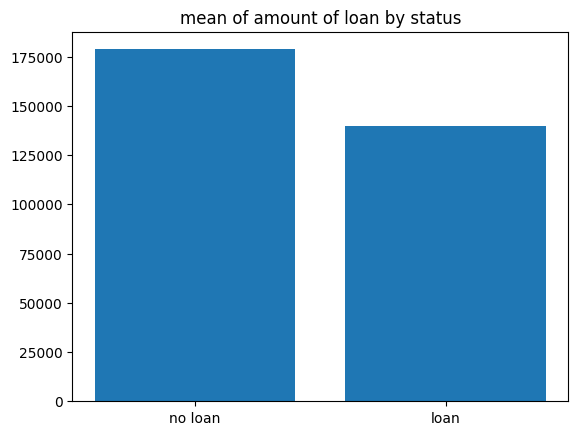

In [112]:
values = joined_df.groupby('status')['amount'].mean()
plt.title("mean of amount of loan by status")
plt.bar(["no loan", "loan"], values)

This barplot shows the mean of the amount of the loan for each case, if the loan was given or not. We can see that the amount for cases where the loan was not given was higher than for the ones that the loan was given.

# Total interest accumulated

In [113]:
grouped = trans_dev_df.groupby("account_id")
account_balance_df = trans_dev_df[['account_id', 'k_symbol', 'amount']]

interst_mean_df = pd.DataFrame(columns=["account_id", "interest_mean"])

for acc_id, group in grouped:
    interst_mean = abs(group[group["k_symbol"] == "interest credited"]["amount"].mean())
    interst_mean_df = interst_mean_df.append({"account_id": int(acc_id), "interest_mean": interst_mean}, ignore_index=True)

joined_df["interest_mean"] = interst_mean_df["interest_mean"]
joined_df["interest_mean"].fillna(0.0, inplace=True)

joined_df.head()

C:\Users\andre\AppData\Local\Temp\ipykernel_24660\525171098.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24660\525171098.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24660\525171098.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24660\525171098.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24660\525171098.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,payments,status,season_on_loan,loan_year,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before,interest_mean
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,8033,-1,spring,1993,45.794233,0,11000.0,0.0,0.0,74.814286
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,4610,1,autumn,1993,25.295523,0,52208.9,52208.9,106447.2,128.930000
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,2118,1,summer,1993,57.153809,0,20272.8,27619.5,0.0,98.416667
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,2939,1,winter,1993,52.882674,0,40164.0,0.0,0.0,122.782609
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,4579,1,spring,1993,14.754581,0,59527.1,600.0,0.0,30.400000


# Number of times balance droped below five thousand

We calculated the number of times the balance of the account dropped below five thousand because we [found](https://www.czso.cz/csu/czso/2-eng_mzdy_1985_) that the average monthly income from 1990 to 1996 was around that value. Through various runs we found five thoundsand was a good threshhold for the value

In [114]:
account_balance_df.head()

,account_id,k_symbol,amount
0,5270,N/A,800.0
1,5270,N/A,44749.0
2,11265,N/A,1000.0
3,10364,N/A,1100.0
4,3834,N/A,700.0


In [115]:
def get_balance_below_5k(joined_df_row):
    # Get all balance information for account
    account_balances = trans_dev_df[['account_id', 'balance', 'trans_date']][account_balance_df['account_id'] == joined_df_row['account_id']]

    if (account_balances.empty):
        joined_df_row['balance_below_5k'] = 0

        return joined_df_row[['balance_below_5k']]
    
    # Get balance at loan date
    account_balances_below_5k = account_balances.copy()

    account_balances_below_5k = account_balances_below_5k[account_balances_below_5k['balance'] < 5000]

    joined_df_row['balance_below_5k'] = account_balances_below_5k['balance'].count()

    return joined_df_row[['balance_below_5k']]

In [116]:
joined_df[['balance_below_5k']] = joined_df.apply(get_balance_below_5k, axis=1)

In [117]:
joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,status,season_on_loan,loan_year,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before,interest_mean,balance_below_5k
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,-1,spring,1993,45.794233,0,11000.0,0.0,0.0,74.814286,1
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,1,autumn,1993,25.295523,0,52208.9,52208.9,106447.2,128.930000,2
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,1,summer,1993,57.153809,0,20272.8,27619.5,0.0,98.416667,1
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,1,winter,1993,52.882674,0,40164.0,0.0,0.0,122.782609,1
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,1,spring,1993,14.754581,0,59527.1,600.0,0.0,30.400000,1


# Loan Amount / Account Balance

We thought compoaring the loan amount to the bance in the account at the time of the loan would be a good indicator of loan's status

In [118]:
def get_loan_amount_over_balance(row):
    return row['amount'] / row['balance_at_loan'] if row['balance_at_loan'] > 0 else -1

joined_df['loan_amount_over_balance'] = joined_df.apply(get_loan_amount_over_balance, axis=1)

# Loan over 100k

In our analysis of the data we found loans over one hundred thousand had a higher chance of defaulting.

In [119]:
joined_df['loan_over_100k'] = joined_df['amount'] > 100000

### Distributions

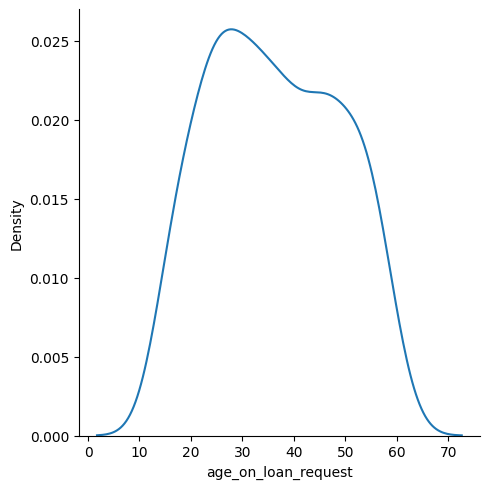

In [120]:
sb.displot(joined_df, x="age_on_loan_request", kind="kde")

This is a distribution of the age of the client at the time they asked for the loan. From this image, we can conclude that most people apply for a loan when they are 30-40 years.

### 3D Scatter Plot
For these graphs, if it's green, it means that the loan was given and if it's red, it means that the loan was not given.

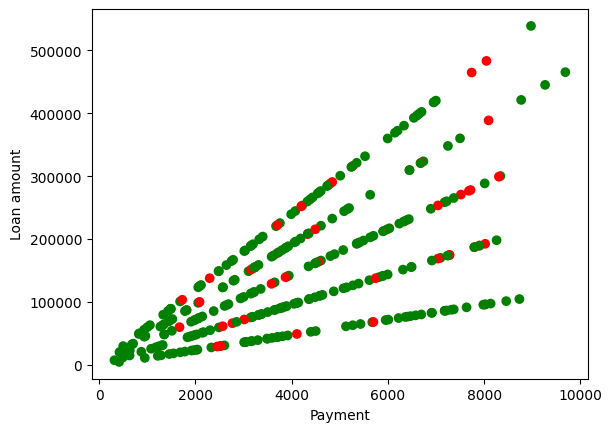

In [121]:
ys = joined_df['amount']
x = joined_df['payments']

colors = ['g' if s == 1 else 'r' for s in joined_df['status']]
plt.ylabel('Loan amount')
plt.xlabel('Payment')
plt.scatter(x, ys, color=colors)

This scatter plot shows the payment and the loan amount (besides the status). We can then conclude that the bigger the payment, the bigger the amount.

## Outliers

In [122]:
joined_df.describe()[['no. of commited crimes \'95', 'age_on_loan_request', 'duration', 'payments']]

,no. of commited crimes '95,age_on_loan_request,duration,payments
count,328.000000,328.000000,328.000000,328.000000
mean,14731.472419,36.242844,35.853659,4150.932927
std,27166.502446,12.559813,16.734752,2193.620989
min,818.000000,13.574543,12.000000,319.000000
25%,2157.000000,25.510449,24.000000,2368.750000
50%,3577.500000,35.536664,36.000000,3878.500000
75%,6949.000000,46.747709,48.000000,5907.750000
max,85677.000000,60.817128,60.000000,9689.000000


In [123]:
import plotly.express as px

fig = px.histogram(joined_df, x='no. of commited crimes \'95')
fig.show()

In [124]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

outliers = find_outliers_IQR(joined_df['no. of commited crimes \'95'])

print("number of outliers: " + str(len(outliers)))

print("max outlier value: " + str(outliers.max()))

print("min outlier value: " + str(outliers.min()))

number of outliers: 60
max outlier value: 85677.0
min outlier value: 18721.0


### Remove underage users

In [125]:
underage = joined_df.loc[joined_df['age_on_loan_request']<18]

joined_df.drop(underage.index, inplace=True)

joined_df.describe()[['age_on_loan_request']]


,age_on_loan_request
count,306.000000
mean,37.716602
std,11.685221
min,18.253626
25%,27.478319
50%,37.279342
75%,47.036558
max,60.817128


# Split into age brackets

We chose to split users into age brackets.

In [126]:
import plotly.express as px

fig = px.histogram(joined_df, x='age_on_loan_request')
fig.show()

In [127]:
def get_age_bracket(age):
    if age >= 18 and age <= 24:
        return '18-24'
    elif age >= 25 and age <= 34:
        return '25-34'
    elif age>= 35 and age <= 44:
        return '35-44'
    elif age >= 45 and age <= 54:
        return '45-54'
    elif age >= 55 and age <= 64:
        return '55-64'
    elif age >= 65:
        return '65+'

joined_df['age_bracket'] = joined_df['age_on_loan_request'].apply(get_age_bracket)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before,interest_mean,balance_below_5k,loan_amount_over_balance,loan_over_100k,age_bracket
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,45.794233,0,11000.0,0.0,0.0,74.814286,1,8.763273,False,45-54
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,25.295523,0,52208.9,52208.9,106447.2,128.930000,2,3.178768,True,25-34
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,57.153809,0,20272.8,27619.5,0.0,98.416667,1,6.268498,True,55-64
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,52.882674,0,40164.0,0.0,0.0,122.782609,1,2.634299,True,45-54
6,11265,monthly issuance,1993-01-14,13537,0,M,15,Cesky Krumlov,south Bohemia,58796,...,20.578109,0,21029.0,24136.1,25279.8,109.802128,1,2.510248,False,18-24


## Set Correct Data Types

In [128]:
joined_df['shared'] = joined_df['shared'].astype('bool')

In [129]:
joined_df['status'] = joined_df['status'].apply(lambda x: 1 if x == -1 else 0)
joined_df['status'] = joined_df['status'].astype('bool')

In [130]:
joined_df.drop(columns=['district_name', 'account_id', 'disp_id', 'age_on_loan_request'], inplace=True)

### Remove Categorical Values

In [131]:
cat = ['sex', 'region', 'issuance_freq', 'season_on_loan', 'age_bracket']

joined_df[cat] = joined_df[cat].astype('category')

joined_df[cat] = joined_df[cat].apply(lambda x : x.cat.codes)

# Clustering - Data Description

In [132]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [133]:
print(joined_df.dtypes)

issuance_freq                                                 int8
acc_creation_date                                   datetime64[ns]
shared                                                        bool
sex                                                           int8
district_code                                                int64
region                                                        int8
no. of inhabitants                                           int64
no. of municipalities with inhabitants < 499                 int64
no. of municipalities with inhabitants 500-1999              int64
no. of municipalities with inhabitants 2000-9999             int64
no. of municipalities with inhabitants >10000                int64
no. of cities                                                int64
ratio of urban inhabitants                                 float64
average salary                                               int64
unemploymant rate '95                                      flo

## PCA

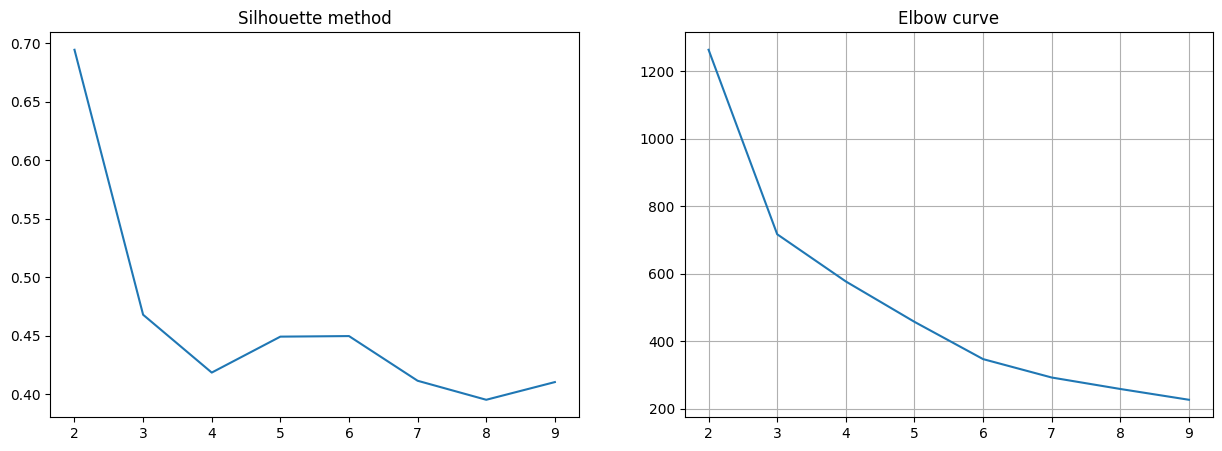

In [134]:
X = joined_df.drop(['status'], axis=1)
X.drop(columns=['acc_creation_date', 'loan_date'], inplace=True)
y = joined_df['status']

X = StandardScaler().fit_transform(X, y)
X = PCA(n_components=2, random_state=42).fit_transform(X)

wss = []
silhouette = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)
    silhouette.append(metrics.silhouette_score(X, kmeans.labels_))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(2, 10), silhouette)
ax[1].plot(range(2, 10), wss)

plt.grid(True)

ax[0].set_title('Silhouette method')
ax[1].set_title('Elbow curve')

plt.show()

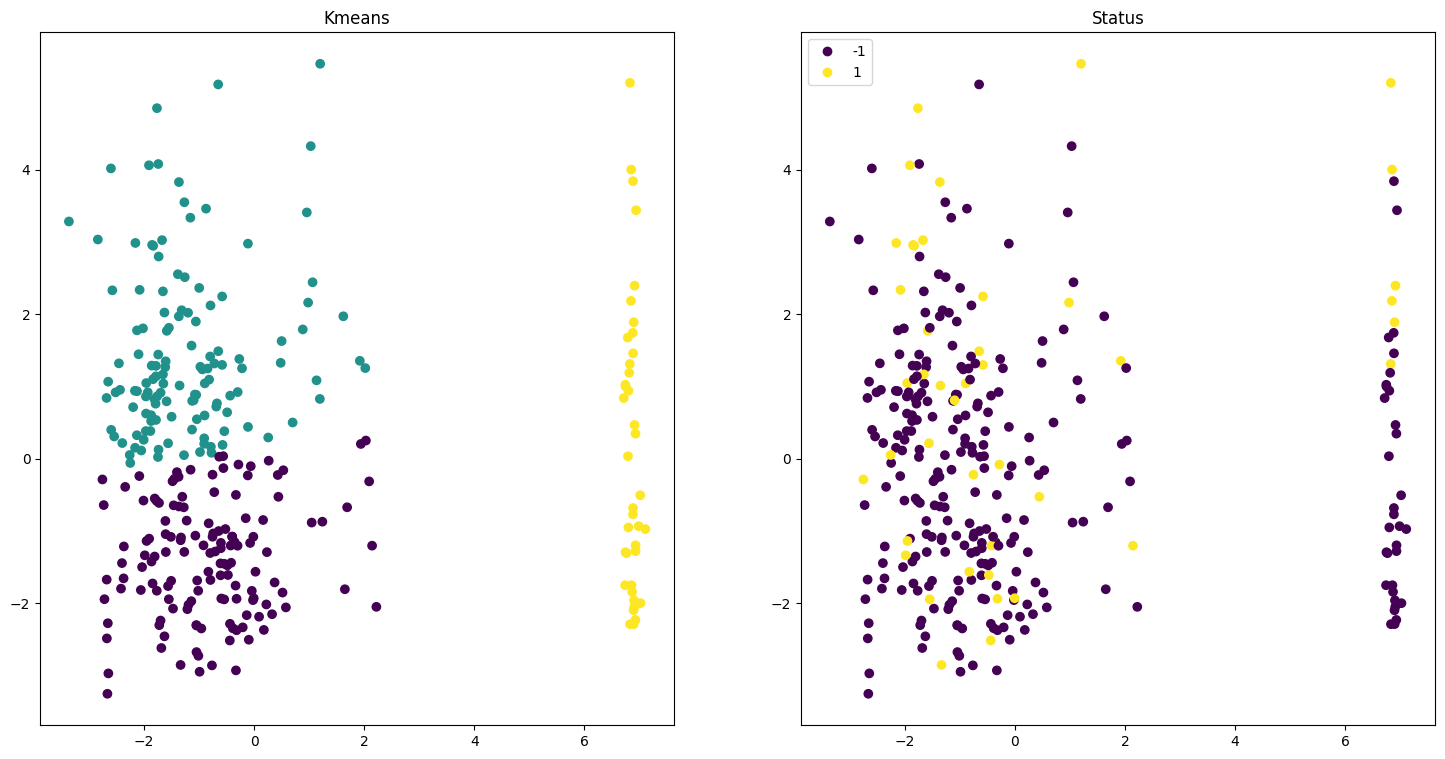

In [135]:
X = joined_df.drop(['status'], axis=1)
X.drop(columns=['acc_creation_date', 'loan_date'], inplace=True)
y = joined_df['status']

X = StandardScaler().fit_transform(X)
X = PCA(n_components=2, random_state=42).fit_transform(X)
db = KMeans(n_clusters=3, random_state=42).fit_predict(X)

# Plot result

fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].scatter(X[:, 0], X[:, 1], c=db)

scatter = axs[1].scatter(X[:, 0], X[:, 1], c=y)

axs[0].set_title("Kmeans")
axs[1].set_title("Status")

axs[1].legend(handles=scatter.legend_elements()[0], labels=[-1, 1])

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

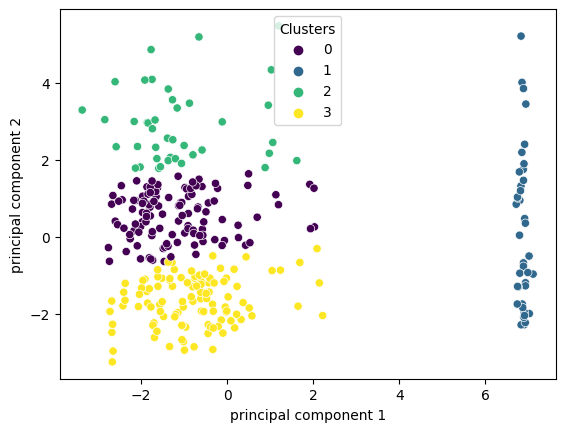

In [136]:
import sklearn.cluster as cluster
import seaborn as sns
kmeans = cluster.KMeans(n_clusters=4, random_state=42)
X=joined_df.drop(['status'],axis=1)
X.drop(columns=['acc_creation_date', 'loan_date'], inplace=True)
y = joined_df["status"]

X = StandardScaler().fit_transform(X)
X = PCA(n_components=2, random_state=42).fit_transform(X)

pca_df = pd.DataFrame(data = X, columns = ['principal component 1', 'principal component 2'])
kmeans = kmeans.fit(pca_df)

pca_df['Clusters'] = kmeans.labels_

sns.scatterplot(x="principal component 1", y="principal component 2",hue = 'Clusters',  data=pca_df,palette='viridis')

# Feature Selection

In [137]:
features = [
    'shared',
    'no. of municipalities with inhabitants < 499',
    'no. of municipalities with inhabitants 500-1999',
    'no. of municipalities with inhabitants 2000-9999',
    'no. of municipalities with inhabitants >10000', 
    'no. of cities',
    'ratio of urban inhabitants', 
    'average salary', 
    'unemploymant rate \'96', 
    'no. of enterpreneurs per 1000 inhabitants',
    'amount', 
    'duration', 
    'payments',
    'age_bracket',
    'card_score', 
    'balance_at_loan',
    'balance_three_months_before',
    'balance_six_months_before',
    'issuance_freq',
    'sex', 
    'district_code',
    'region',
    'season_on_loan',
    'loan_year',
    'interest_mean',
    'balance_below_5k',
    'loan_amount_over_balance',
    'loan_over_100k'
    ]
    
target = 'status'

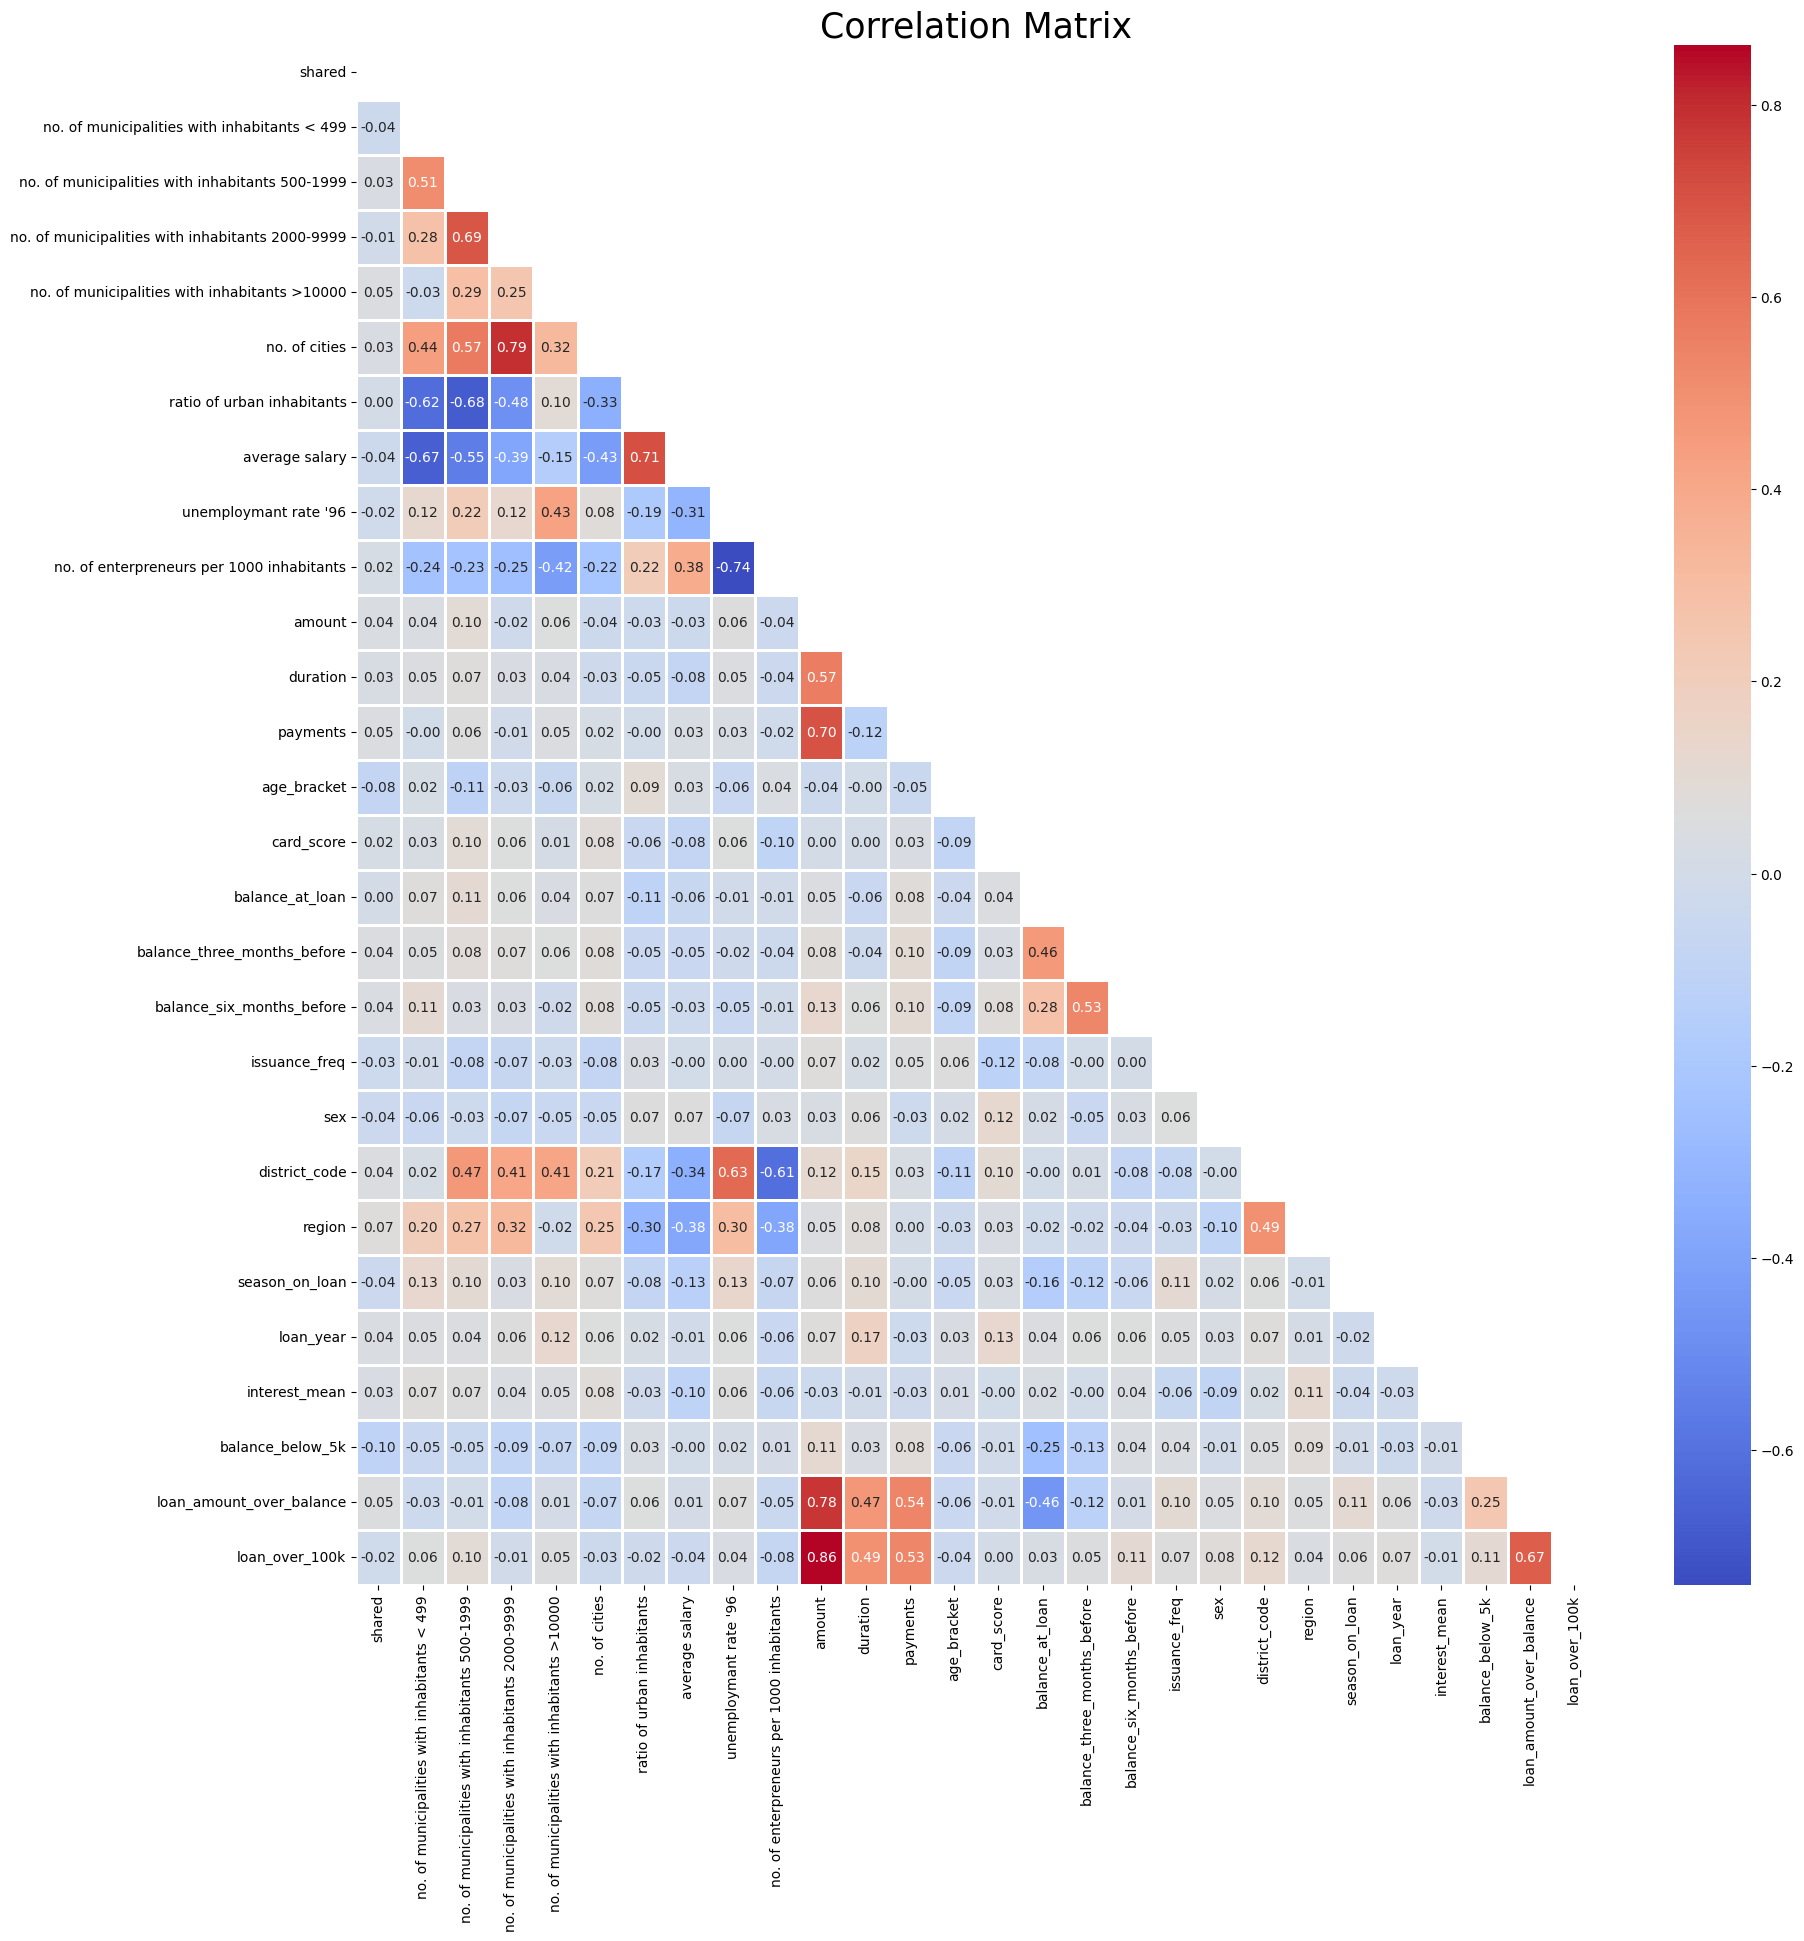

In [138]:
corr_matrix = joined_df[features].corr(method='spearman')

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 20))
plt.title('Correlation Matrix', fontsize=25)
_ = sb.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=2)

plt.show()

### VIF

We are going to test for VIF to check for multicolinearity between features

In [139]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = joined_df[considered_features].copy()
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [140]:
numeric_features = [
    'no. of municipalities with inhabitants < 499',
    'no. of municipalities with inhabitants 500-1999',
    'no. of municipalities with inhabitants 2000-9999',
    'no. of municipalities with inhabitants >10000', 
    'no. of cities',
    'ratio of urban inhabitants', 
    'average salary', 
    'unemploymant rate \'96', 
    'no. of enterpreneurs per 1000 inhabitants',
    'amount', 
    'duration', 
    'payments',
    'card_score', 
    'balance_at_loan',
    'balance_three_months_before',
    'balance_six_months_before',
    'loan_year',
    'interest_mean',
    'balance_below_5k',
    'loan_amount_over_balance'
    ]

vif = compute_vif(numeric_features).sort_values(by='VIF', ascending=False)

vif

,Variable,VIF
9,amount,8.906742
6,average salary,6.648054
5,ratio of urban inhabitants,6.222170
11,payments,5.847024
2,no. of municipalities with inhabitants 2000-9999,4.797909
10,duration,4.769556
8,no. of enterpreneurs per 1000 inhabitants,4.557196
4,no. of cities,3.791772
1,no. of municipalities with inhabitants 500-1999,3.731887
7,unemploymant rate '96,2.994342


VIF threshhold at 5. removing amount and recalculating

In [141]:
numeric_features.remove('amount')

vif = compute_vif(numeric_features).sort_values(by='VIF', ascending=False)

vif

,Variable,VIF
6,average salary,6.642614
5,ratio of urban inhabitants,6.219370
2,no. of municipalities with inhabitants 2000-9999,4.797874
8,no. of enterpreneurs per 1000 inhabitants,4.541628
4,no. of cities,3.782697
1,no. of municipalities with inhabitants 500-1999,3.701492
7,unemploymant rate '96,2.980716
0,no. of municipalities with inhabitants < 499,2.601644
18,loan_amount_over_balance,2.467914
3,no. of municipalities with inhabitants >10000,1.865481


VIF on payments improved.

In [142]:
numeric_features.remove('average salary')

vif = compute_vif(numeric_features).sort_values(by='VIF', ascending=False)

vif

,Variable,VIF
2,no. of municipalities with inhabitants 2000-9999,4.285216
5,ratio of urban inhabitants,3.794121
1,no. of municipalities with inhabitants 500-1999,3.690464
7,no. of enterpreneurs per 1000 inhabitants,3.640683
6,unemploymant rate '96,2.969377
4,no. of cities,2.846561
0,no. of municipalities with inhabitants < 499,2.600999
17,loan_amount_over_balance,2.466018
3,no. of municipalities with inhabitants >10000,1.861589
11,balance_at_loan,1.804612


All VIF values in threshold

In [143]:
features.remove('average salary')
features.remove('amount')

<AxesSubplot:xlabel='season_on_loan', ylabel='duration'>

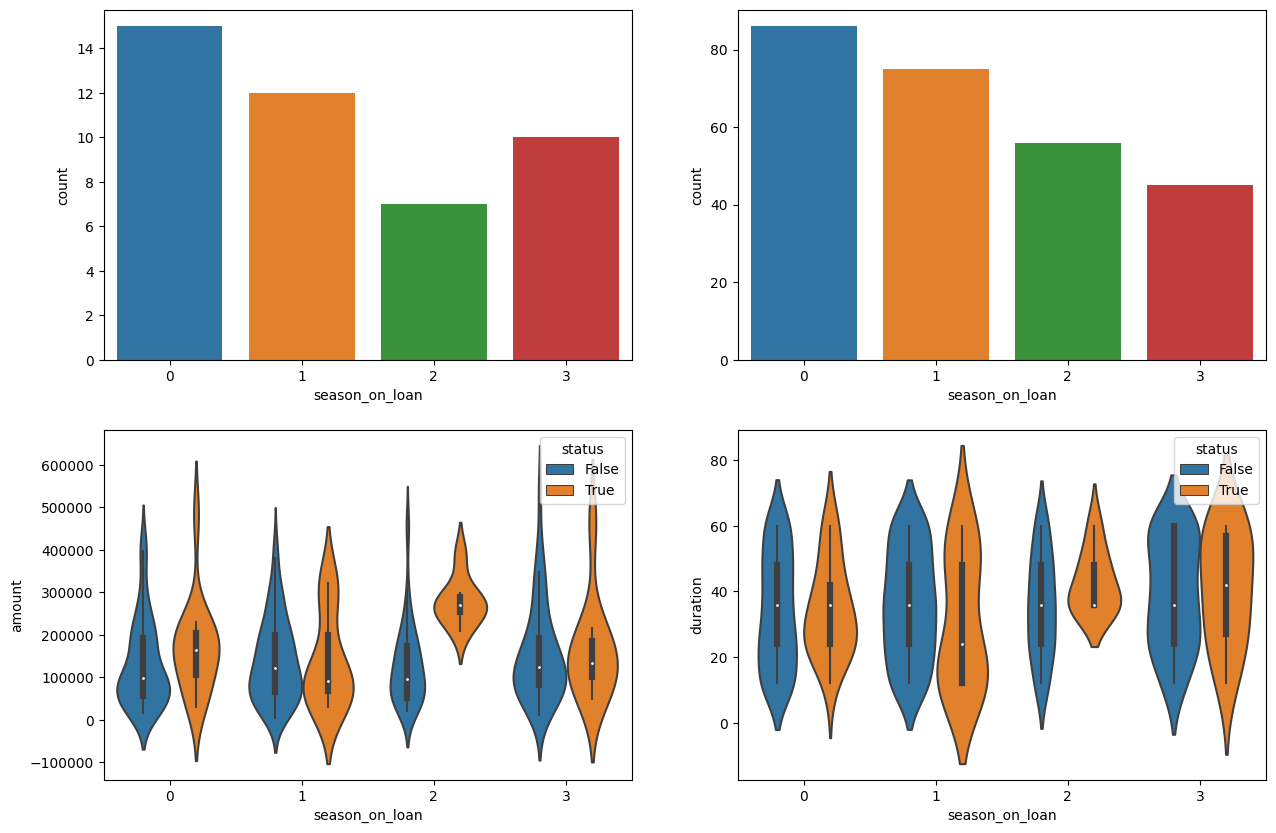

In [144]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 10)
sb.countplot(x="season_on_loan", data=joined_df[joined_df["status"] == 1], ax=ax[0][0])
sb.countplot(x="season_on_loan", data=joined_df[joined_df["status"] != 1], ax=ax[0][1])
sb.violinplot(x="season_on_loan", y="amount", data=joined_df, hue="status", ax=ax[1][0])
sb.violinplot(x="season_on_loan", y="duration", data=joined_df, hue="status", ax=ax[1][1])


Throughout the year the amount of accepted loans is descreasing. We can also notice in autumn the lower bound of loans are higher.

In [146]:
print(joined_df.columns)

Index(['issuance_freq', 'acc_creation_date', 'shared', 'sex', 'district_code',
       'region', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999',
       'no. of municipalities with inhabitants >10000', 'no. of cities',
       'ratio of urban inhabitants', 'average salary', 'unemploymant rate '95',
       'unemploymant rate '96', 'no. of enterpreneurs per 1000 inhabitants',
       'no. of commited crimes '95', 'no. of commited crimes '96', 'loan_id',
       'loan_date', 'amount', 'duration', 'payments', 'status',
       'season_on_loan', 'loan_year', 'card_score', 'balance_at_loan',
       'balance_three_months_before', 'balance_six_months_before',
       'interest_mean', 'balance_below_5k', 'loan_amount_over_balance',
       'loan_over_100k', 'age_bracket'],
      dtype='object')


### ANOVA

In [147]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def do_anova(cols, k="all"):
    best_features = SelectKBest(score_func=f_classif, k=k)
    df_cut = joined_df[cols]
    fit = best_features.fit(df_cut, joined_df["status"])
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_cut.columns)

    # concat 2 dataFrame for better visualization
    feature_score = pd.concat([dfcolumns, dfscores], axis=1)
    feature_score.columns = ["Features", "Score"]
    ret = feature_score.sort_values(by="Score", ascending=False)
    return ret.head(k) if k != "all" else ret

In [148]:
do_anova(features)

,Features,Score
23,balance_below_5k,54.990790
24,loan_amount_over_balance,27.311348
0,shared,15.936819
13,balance_at_loan,10.143509
10,payments,7.425428
15,balance_six_months_before,4.132036
25,loan_over_100k,3.861185
14,balance_three_months_before,3.381195
1,no. of municipalities with inhabitants < 499,2.917119
5,no. of cities,2.661901


In [149]:
selected_features = [
    'shared',
    'balance_at_loan',
    'payments',
    'balance_six_months_before',
    'balance_three_months_before',
    'season_on_loan',
    'age_bracket',
    'loan_year',
    'interest_mean',
    'balance_below_5k',
    'loan_amount_over_balance',
    ]

# Algorithms

In [150]:
print(joined_df.columns)

Index(['issuance_freq', 'acc_creation_date', 'shared', 'sex', 'district_code',
       'region', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999',
       'no. of municipalities with inhabitants >10000', 'no. of cities',
       'ratio of urban inhabitants', 'average salary', 'unemploymant rate '95',
       'unemploymant rate '96', 'no. of enterpreneurs per 1000 inhabitants',
       'no. of commited crimes '95', 'no. of commited crimes '96', 'loan_id',
       'loan_date', 'amount', 'duration', 'payments', 'status',
       'season_on_loan', 'loan_year', 'card_score', 'balance_at_loan',
       'balance_three_months_before', 'balance_six_months_before',
       'interest_mean', 'balance_below_5k', 'loan_amount_over_balance',
       'loan_over_100k', 'age_bracket'],
      dtype='object')


In [151]:
print(joined_df.dtypes)

issuance_freq                                                 int8
acc_creation_date                                   datetime64[ns]
shared                                                        bool
sex                                                           int8
district_code                                                int64
region                                                        int8
no. of inhabitants                                           int64
no. of municipalities with inhabitants < 499                 int64
no. of municipalities with inhabitants 500-1999              int64
no. of municipalities with inhabitants 2000-9999             int64
no. of municipalities with inhabitants >10000                int64
no. of cities                                                int64
ratio of urban inhabitants                                 float64
average salary                                               int64
unemploymant rate '95                                      flo

In [152]:
X = joined_df[selected_features]
y = joined_df[target]

In [153]:
print(X.shape)

(306, 11)


In [154]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) # 70% training and 30% test


### Normalization
Some of the algorithms we plan on using (KNN and SVM) require the data to be standardized. To do so, we used a StandardScaler from SciKit Learn's preprocessing library.

In [155]:
scaler = sk.preprocessing.StandardScaler()

scaler.fit(X_train)
x_train_fitted = scaler.fit_transform(X_train)
x_test_fitted = scaler.fit_transform(X_test)

## Descision Tree

In [156]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(min_samples_leaf=15, max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [157]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.93181818 0.06818182]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [0.5        0.5       ]
 [0.93333333 0.06666667]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.77272727 0.22727273]
 [0.5        0.5       ]
 [1.         0.        ]


Recall: 0.0
Precision: 0.0


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



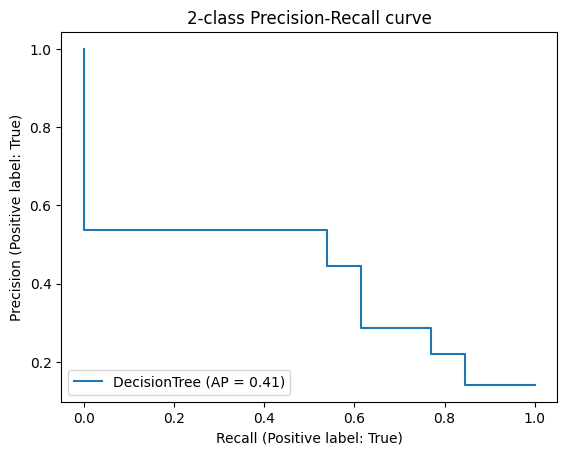

In [158]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import PrecisionRecallDisplay

print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="DecisionTree"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

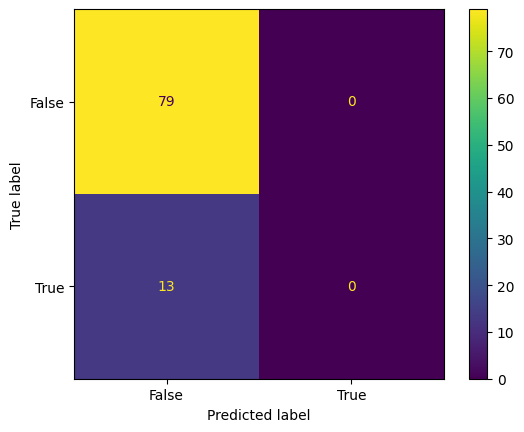

In [159]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

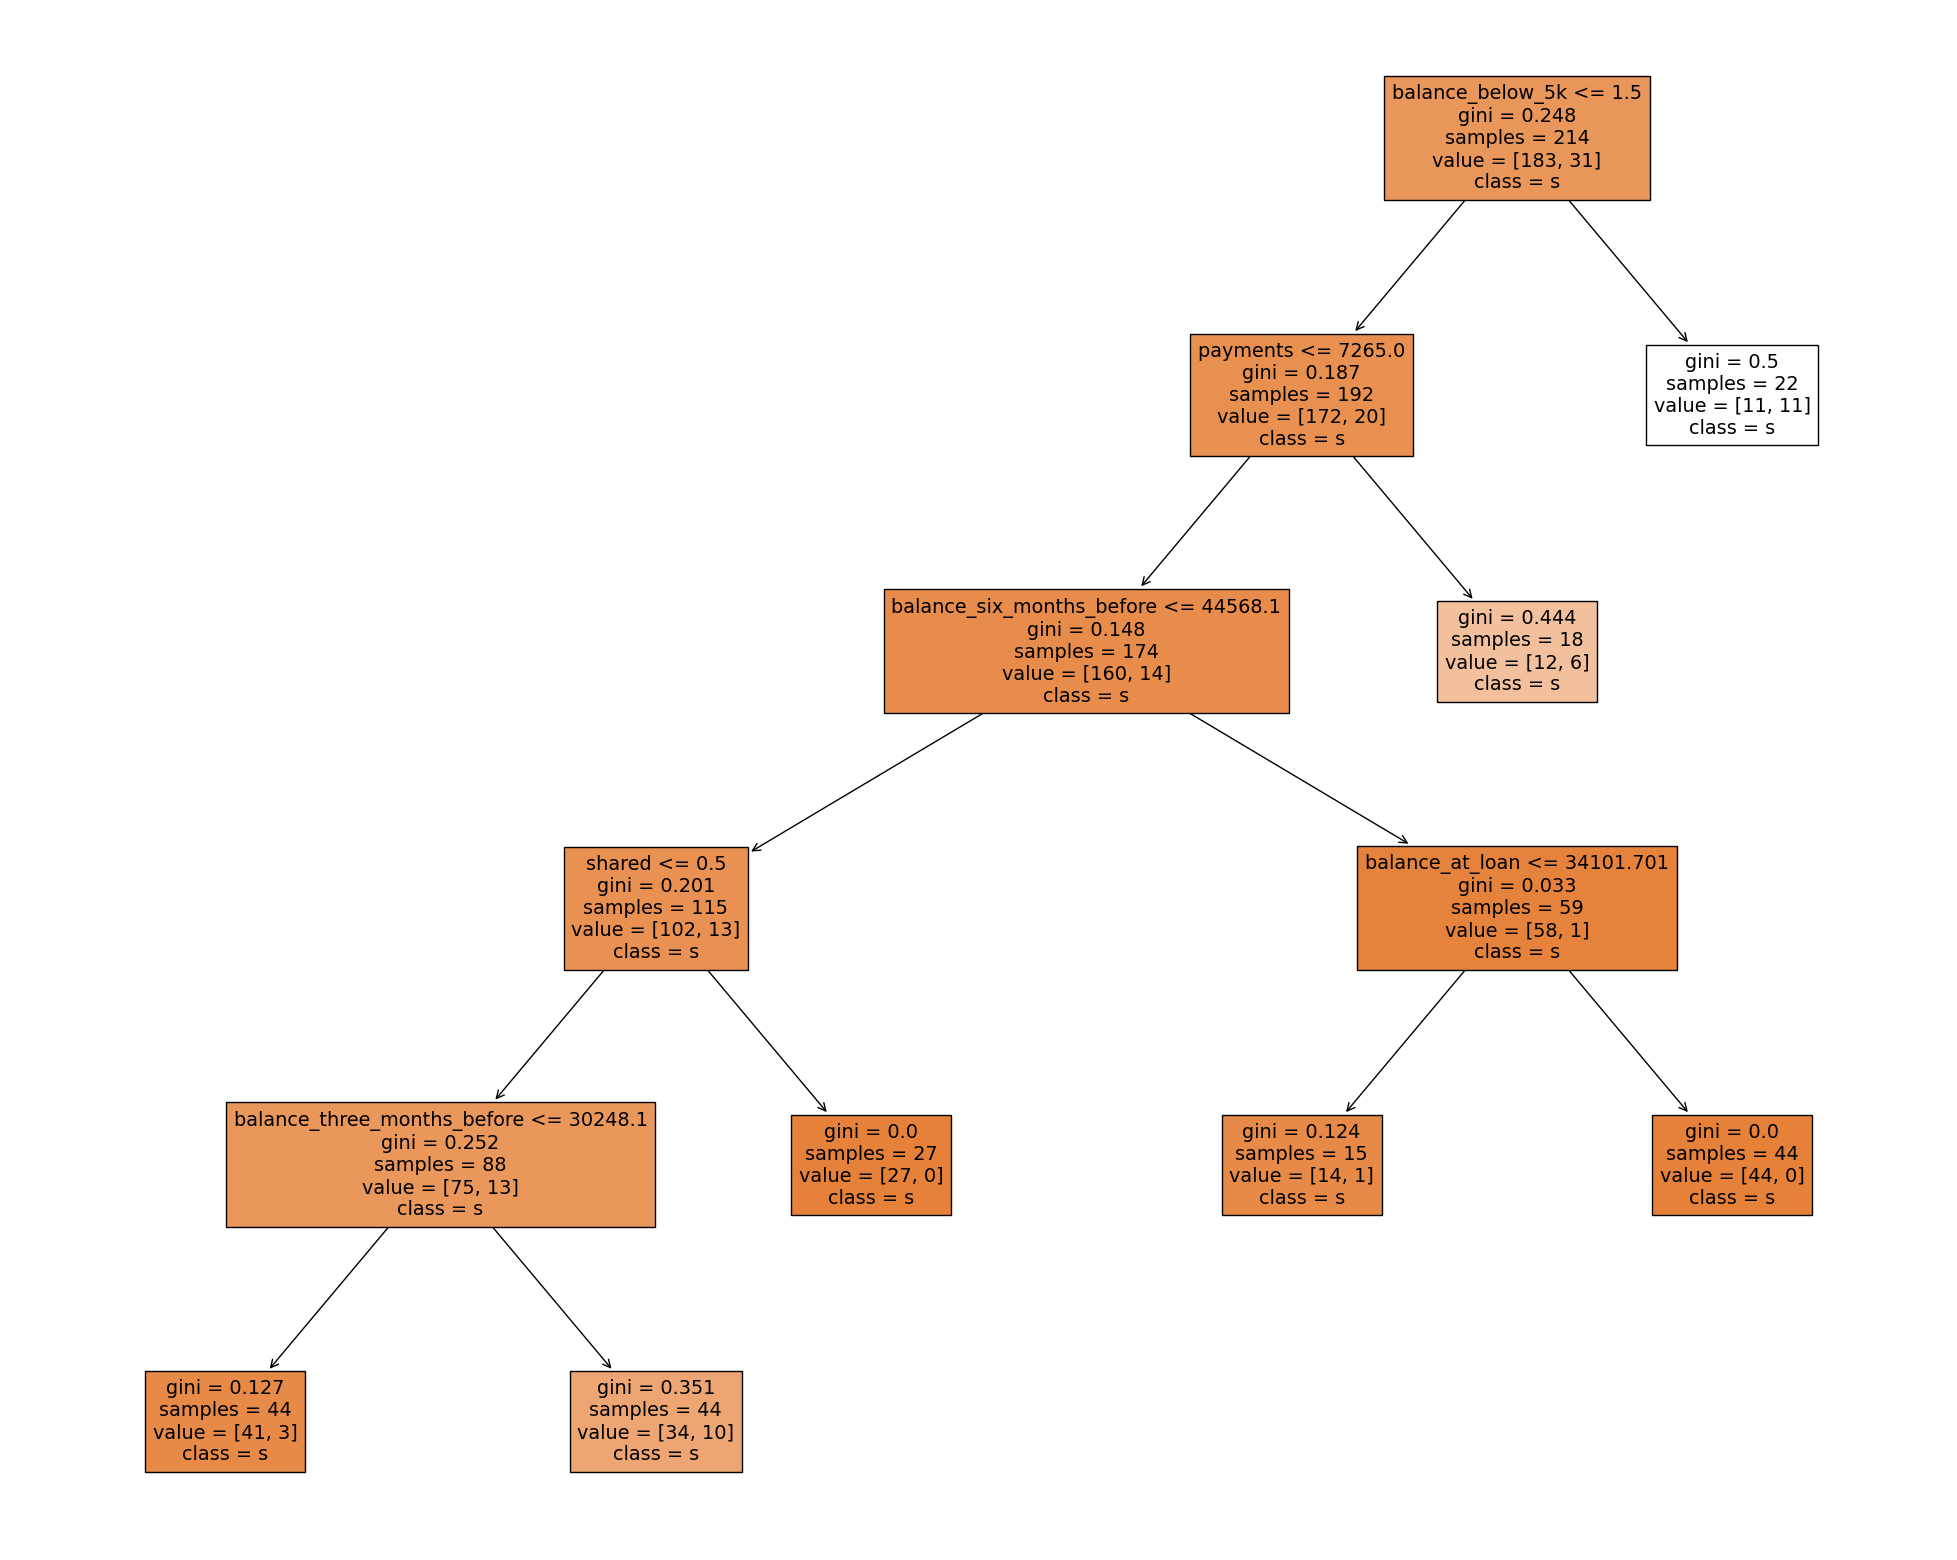

In [160]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=selected_features,  
                   class_names=target,
                   filled=True)


## SVC

0.8551401869158879
REcall:  0.0
Precison:  0.0


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



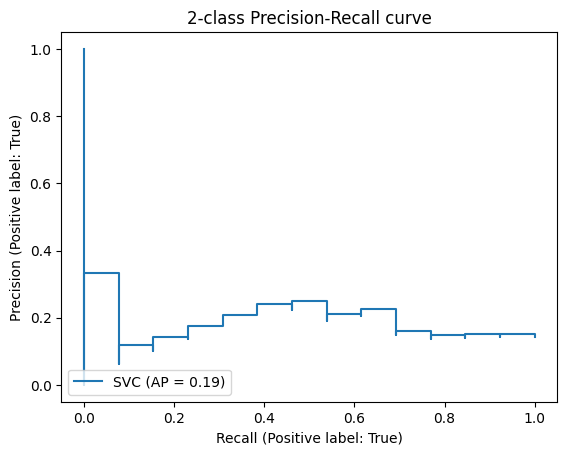

In [162]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import PrecisionRecallDisplay

# lsvc = SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
#  max_iter=-1, probability=True, random_state=1234, shrinking=True, tol=0.001, verbose=False)

lsvc = SVC(verbose=0, C=0.01, kernel='poly')

lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(x_test_fitted)

score = lsvc.score(x_train_fitted, y_train)
print(score)
print("REcall: ", metrics.recall_score(y_test, y_pred))
print("Precison: ", metrics.precision_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    lsvc, X_test, y_test, name="SVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


In [163]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.93181818 0.06818182]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [0.5        0.5       ]
 [0.93333333 0.06666667]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.77272727 0.22727273]
 [0.5        0.5       ]
 [1.         0.        ]


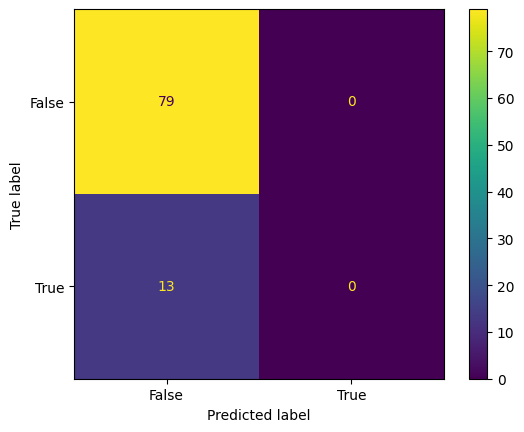

In [164]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## KNN

In [165]:
knn = sk.neighbors.KNeighborsClassifier(
    n_neighbors=50,
    weights='distance',
    algorithm='ball_tree',
    leaf_size=1,
    n_jobs=-1
    )

knn.fit(x_train_fitted, y_train)
y_pred = knn.predict(x_test_fitted)
print(sk.metrics.accuracy_score(y_test, y_pred))
print("Recall: ",sk.metrics.recall_score(y_test, y_pred))
print("Precision: ", sk.metrics.precision_score(y_test, y_pred))
print("AUROC: ", sk.metrics.roc_auc_score(y_test, y_pred))

0.8586956521739131
Recall:  0.0
Precision:  0.0
AUROC:  0.5


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



## Logistic Regression

Recall:  0.6923076923076923
Precision:  0.36
AUROC:  0.744888023369036
Accuracy:  0.782608695652174


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed



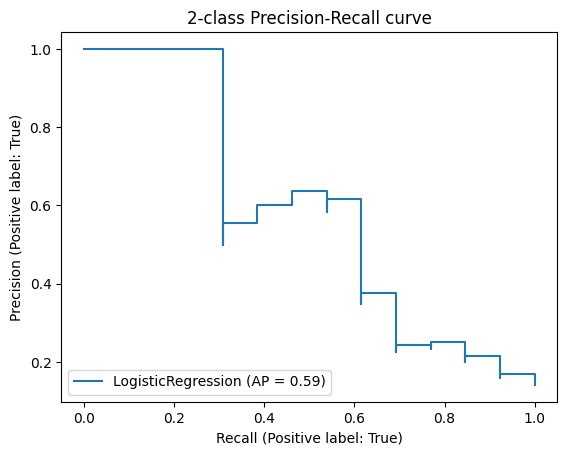

In [166]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import PrecisionRecallDisplay


# logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr = LogisticRegression(C=0.01, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
 l1_ratio=None, max_iter=1000, multi_class='multinomial', n_jobs=None, penalty='l2', random_state=1234, solver='newton-cg',
  tol=0.0001, verbose=0, warm_start=False)

logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    logisticRegr, X_test, y_test, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


In [167]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.93181818 0.06818182]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [0.5        0.5       ]
 [0.93333333 0.06666667]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.77272727 0.22727273]
 [0.5        0.5       ]
 [1.         0.        ]


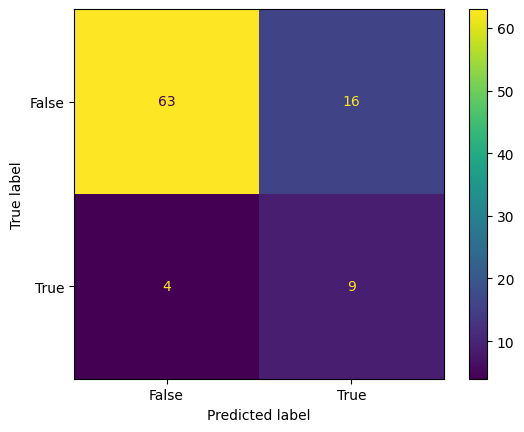

In [168]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## LGBMC

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



0.9953271028037384
REcall:  0.5384615384615384
Precison:  0.6363636363636364


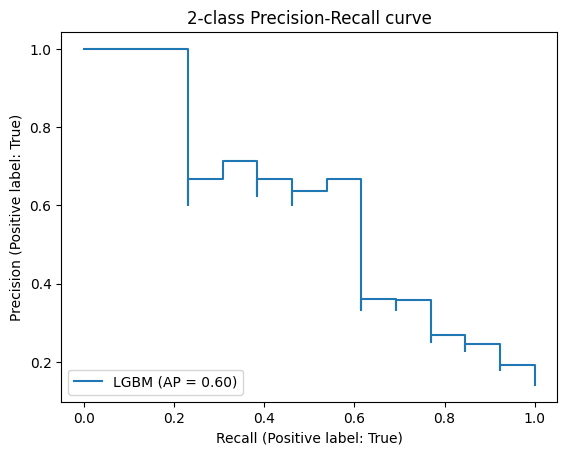

In [169]:
from lightgbm import LGBMClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import PrecisionRecallDisplay

lgbm = LGBMClassifier(task = 'train', objective='binary', num_classes = 1, random_state=0, learning_rate = 0.0005, num_iterations = 10000)
# 'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'num_class':3,
#     'metric': 'multi_logloss',
#     'learning_rate': 0.002296,
#     'max_depth': 7,
#     'num_leaves': 17,
#     'feature_fraction': 0.4,
#     'bagging_fraction': 0.6,
#     'bagging_freq': 17
lgbm.fit(X_train, y_train)


y_pred = lgbm.predict(X_test)   
# lgbm.f1
score = lgbm.score(X_train, y_train)
print(score)
print("REcall: ", metrics.recall_score(y_test, y_pred))
print("Precison: ", metrics.precision_score(y_test, y_pred))


display = PrecisionRecallDisplay.from_estimator(
    lgbm, X_test, y_test, name="LGBM"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [170]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.93181818 0.06818182]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [0.5        0.5       ]
 [0.93333333 0.06666667]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.93181818 0.06818182]
 [0.93181818 0.06818182]
 [1.         0.        ]
 [0.5        0.5       ]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [0.77272727 0.22727273]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.77272727 0.22727273]
 [0.5        0.5       ]
 [1.         0.        ]


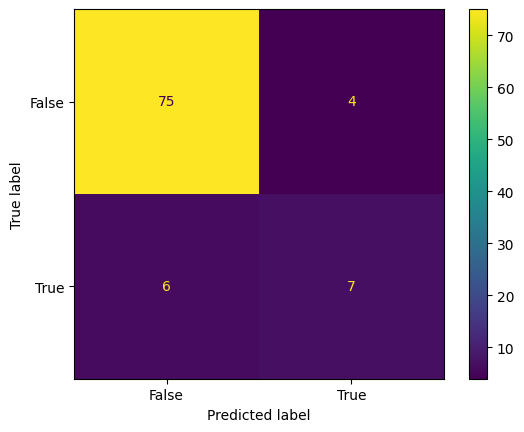

In [171]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

# SMOTE

In [173]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=1234)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [175]:
scaler = sk.preprocessing.StandardScaler()

scaler.fit(X_train)
x_train_fitted_smote = scaler.fit_transform(X_train_smote)
x_test_fitted = scaler.fit_transform(X_test)

## Decision Tree

In [176]:
print(X_train_smote.shape)

(366, 11)


In [177]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train_smote,y_train_smote)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [178]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.7        0.3       ]
 [1.         0.        ]
 [0.40740741 0.59259259]
 [0.27966102 0.72033898]
 [0.27966102 0.72033898]
 [0.76923077 0.23076923]
 [0.27966102 0.72033898]
 [0.9        0.1       ]
 [1.         0.        ]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [1.         0.        ]
 [0.40740741 0.59259259]
 [1.         0.        ]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.7        0.3       ]
 [0.03174603 0.96825397]
 [0.03174603 0.96825397]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.27966102 0.72033898]
 [1.         0.        ]
 [0.8        0.2       ]
 [0.03174603 0.96825397]
 [1.         0.        ]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [0.03174603 0.96825397]
 [0.36842105 0.63157895]
 [0.36842105 0.63157895]
 [0.9        0.1       ]


In [179]:
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Recall:  0.7692307692307693
Precision:  0.29411764705882354
AUROC:  0.7327166504381694
Accuracy:  0.7065217391304348


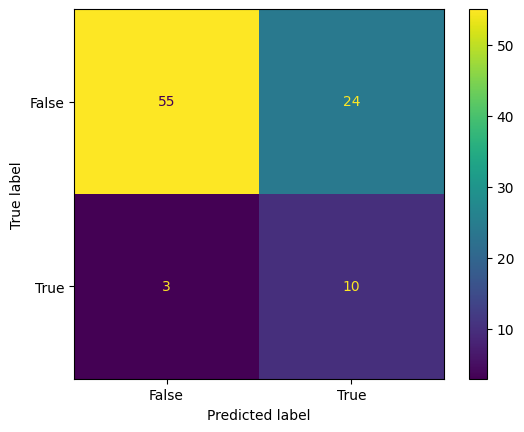

In [180]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

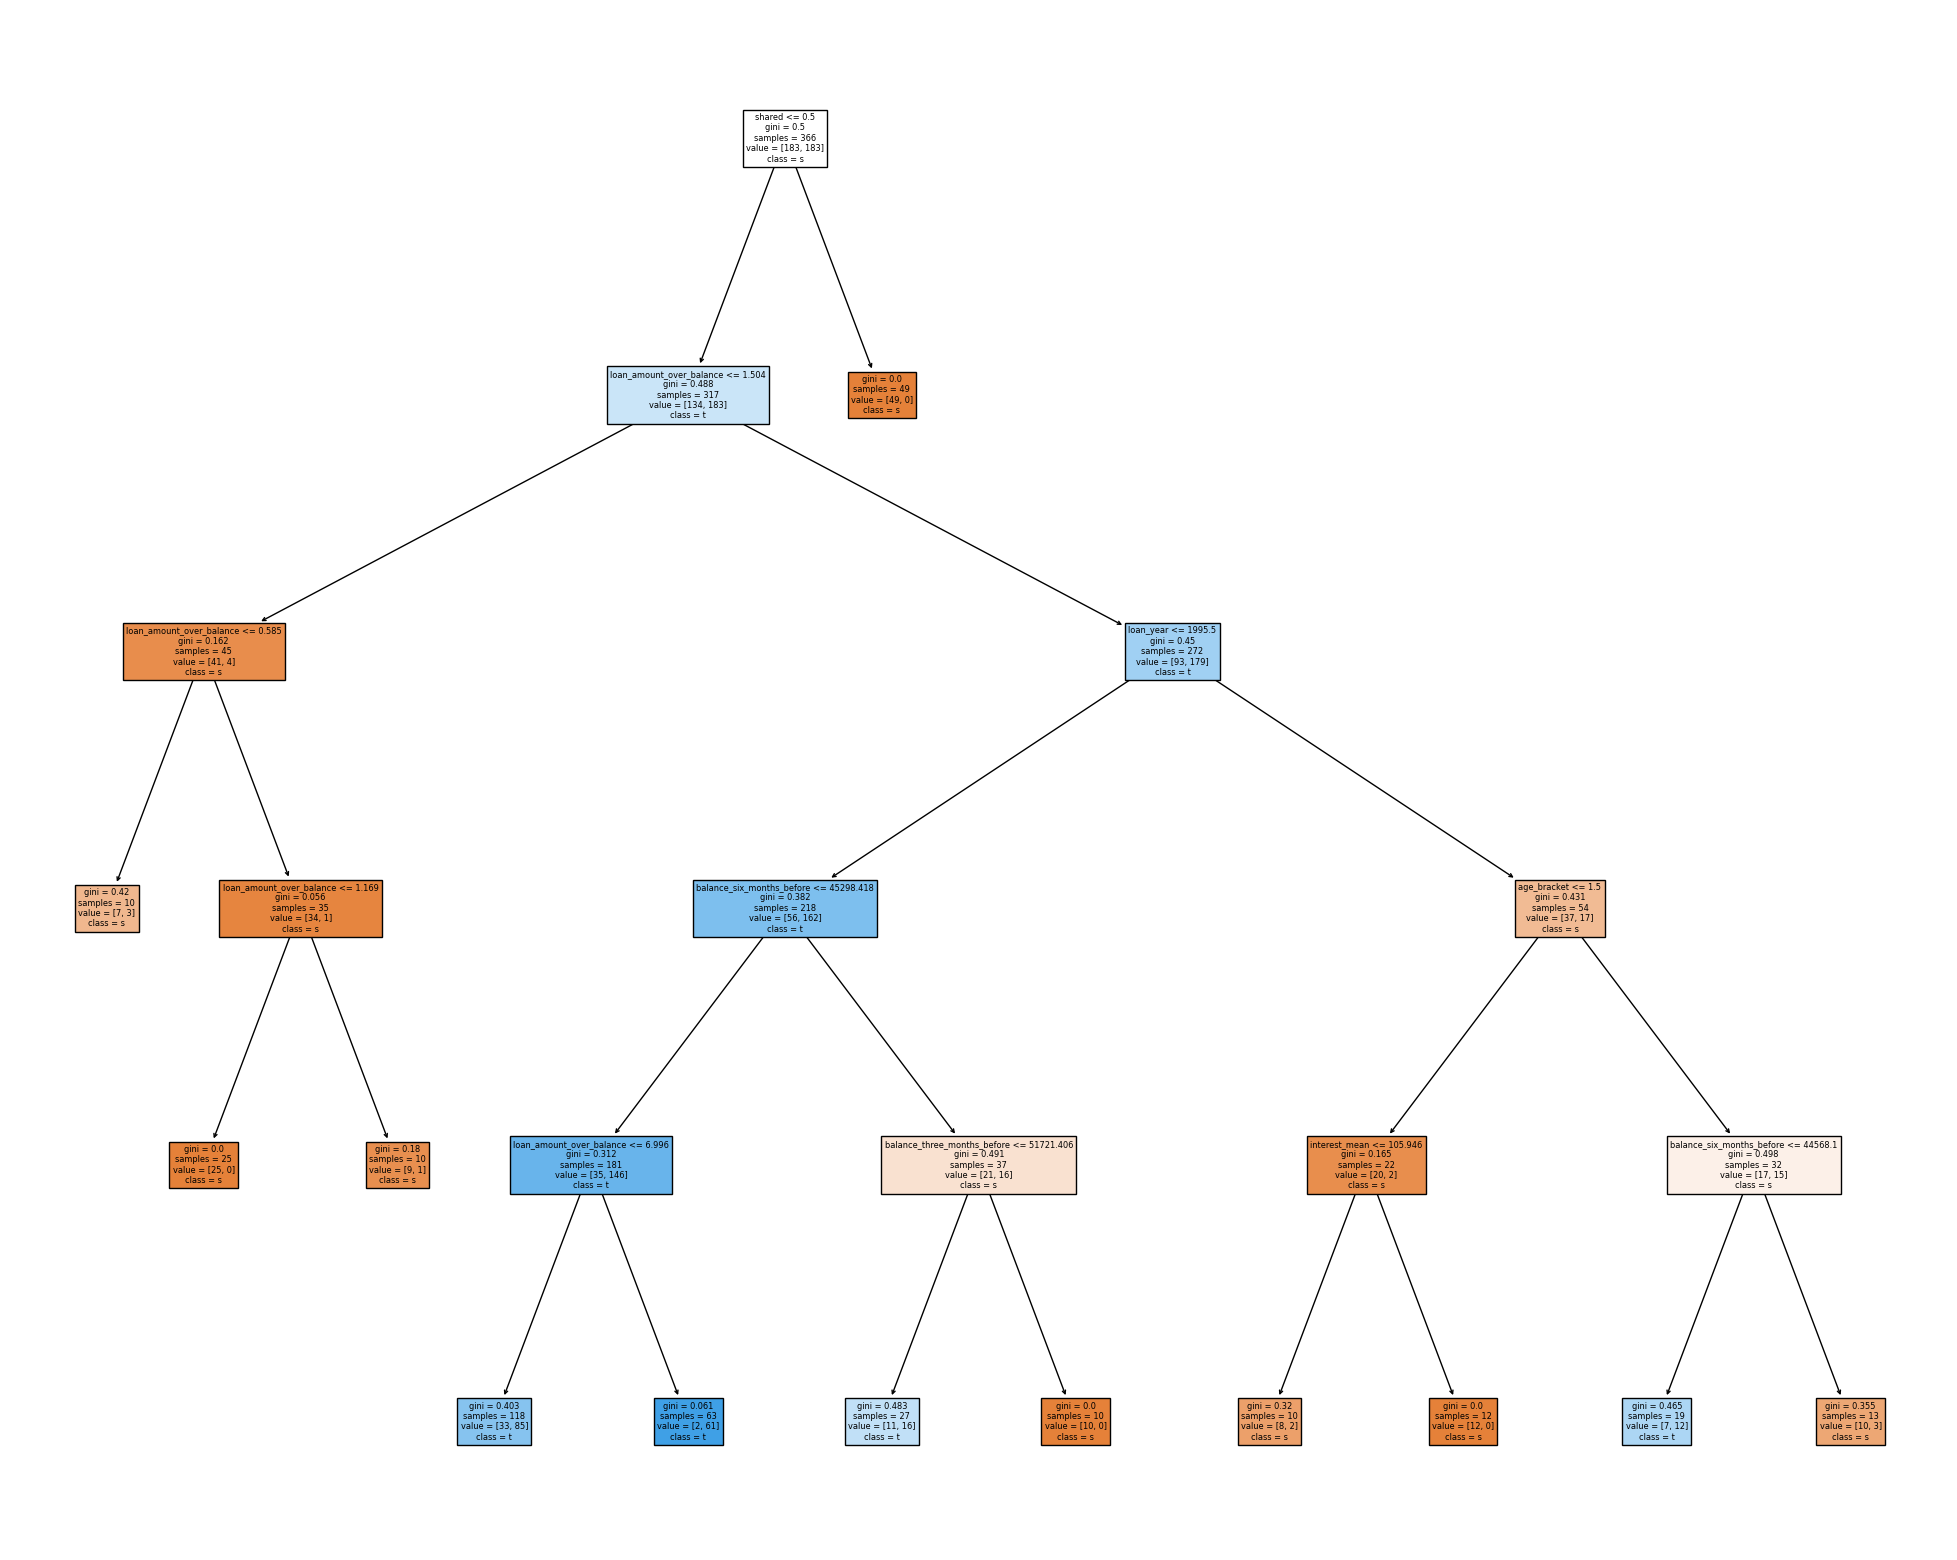

In [181]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=selected_features,  
                   class_names=target,
                   filled=True)

## SVC

Recall:  0.0
Precision:  0.0
AUROC:  0.5
Accuracy:  0.8586956521739131


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but SVC was fitted without feature names

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but SVC was fitted without feature names



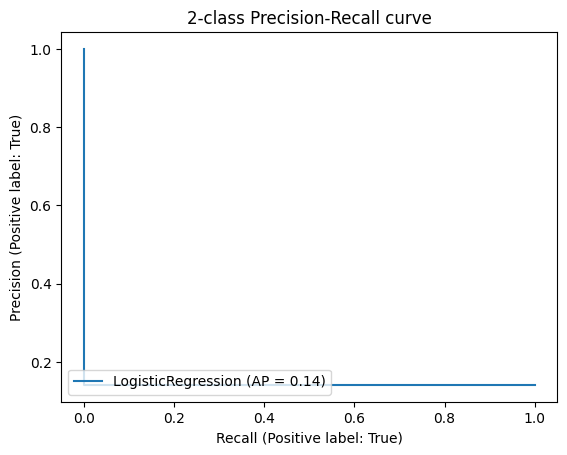

In [182]:
from sklearn.svm import SVC
from sklearn.metrics import PrecisionRecallDisplay

lsvc = SVC(verbose=0, C=0.5, kernel='rbf', probability=True)

lsvc.fit(x_train_fitted_smote, y_train_smote)
y_pred = lsvc.predict(X_test)

print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    lsvc, X_test, y_test, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [105]:
y_pred_proba = lsvc.predict_proba(X_test)
print(y_pred_proba)

[[0.41984686 0.58015314]
 [0.31530648 0.68469352]
 [0.45649586 0.54350414]
 [0.63391487 0.36608513]
 [0.68719516 0.31280484]
 [0.62001476 0.37998524]
 [0.77874893 0.22125107]
 [0.82682434 0.17317566]
 [0.34762805 0.65237195]
 [0.77141722 0.22858278]
 [0.59764177 0.40235823]
 [0.46671614 0.53328386]
 [0.33588439 0.66411561]
 [0.80325177 0.19674823]
 [0.50787491 0.49212509]
 [0.66306575 0.33693425]
 [0.35945562 0.64054438]
 [0.73737543 0.26262457]
 [0.65231167 0.34768833]
 [0.6647685  0.3352315 ]
 [0.79593985 0.20406015]
 [0.31606916 0.68393084]
 [0.3013887  0.6986113 ]
 [0.79487837 0.20512163]
 [0.64548603 0.35451397]
 [0.65475801 0.34524199]
 [0.35481032 0.64518968]
 [0.61567063 0.38432937]
 [0.43273476 0.56726524]
 [0.47717552 0.52282448]
 [0.39975588 0.60024412]
 [0.75159712 0.24840288]
 [0.511388   0.488612  ]
 [0.72646479 0.27353521]
 [0.31441529 0.68558471]
 [0.82618238 0.17381762]
 [0.35275245 0.64724755]
 [0.41900988 0.58099012]
 [0.34369753 0.65630247]
 [0.76224432 0.23775568]


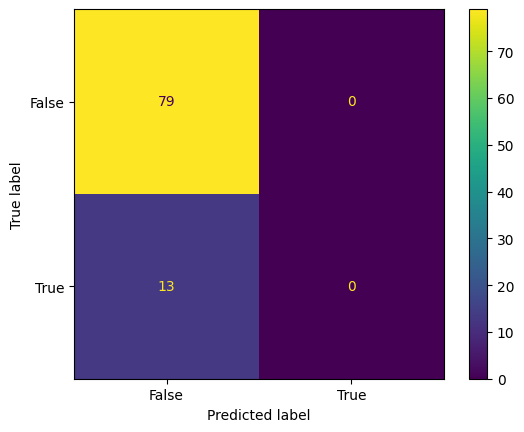

In [183]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## Logistic Regression

Recall:  0.6923076923076923
Precision:  0.36
AUROC:  0.744888023369036
Accuracy:  0.782608695652174


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed



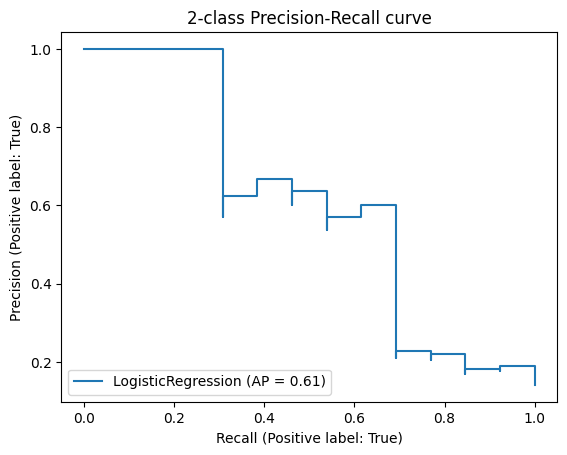

In [184]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import PrecisionRecallDisplay


# logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr = LogisticRegression(C=0.01, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
 l1_ratio=None, max_iter=1000, multi_class='multinomial', n_jobs=None, penalty='l2', random_state=1234, solver='newton-cg',
  tol=0.0001, verbose=0, warm_start=False)

logisticRegr.fit(X_train_smote, y_train_smote)
y_pred = logisticRegr.predict(X_test)

print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    logisticRegr, X_test, y_test, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [185]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.7        0.3       ]
 [1.         0.        ]
 [0.40740741 0.59259259]
 [0.27966102 0.72033898]
 [0.27966102 0.72033898]
 [0.76923077 0.23076923]
 [0.27966102 0.72033898]
 [0.9        0.1       ]
 [1.         0.        ]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [1.         0.        ]
 [0.40740741 0.59259259]
 [1.         0.        ]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.7        0.3       ]
 [0.03174603 0.96825397]
 [0.03174603 0.96825397]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.27966102 0.72033898]
 [1.         0.        ]
 [0.8        0.2       ]
 [0.03174603 0.96825397]
 [1.         0.        ]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [0.03174603 0.96825397]
 [0.36842105 0.63157895]
 [0.36842105 0.63157895]
 [0.9        0.1       ]


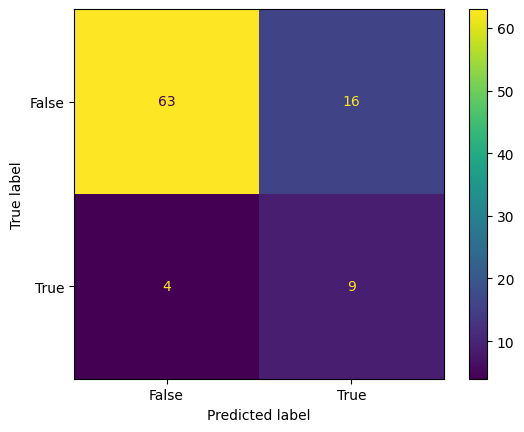

In [186]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## LGBMC

Recall:  0.7692307692307693
Precision:  0.4166666666666667
AUROC:  0.7960077896786757
Accuracy:  0.8152173913043478


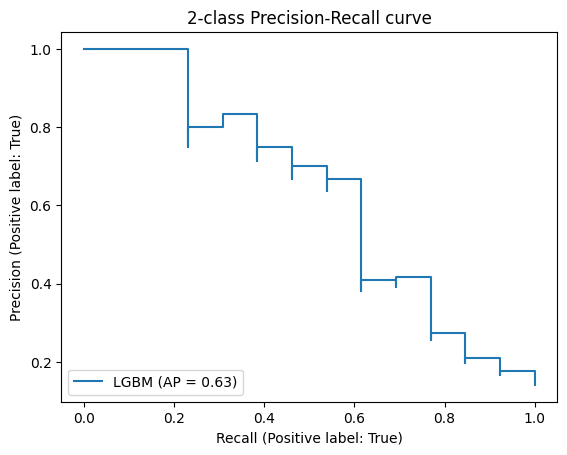

In [187]:
from lightgbm import LGBMClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import PrecisionRecallDisplay

lgbm = LGBMClassifier(objective='binary', random_state=0)
lgbm.fit(X_train_smote, y_train_smote)


y_pred = lgbm.predict(X_test)   

print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))


display = PrecisionRecallDisplay.from_estimator(
    lgbm, X_test, y_test, name="LGBM"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [188]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.7        0.3       ]
 [1.         0.        ]
 [0.40740741 0.59259259]
 [0.27966102 0.72033898]
 [0.27966102 0.72033898]
 [0.76923077 0.23076923]
 [0.27966102 0.72033898]
 [0.9        0.1       ]
 [1.         0.        ]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [1.         0.        ]
 [0.40740741 0.59259259]
 [1.         0.        ]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.7        0.3       ]
 [0.03174603 0.96825397]
 [0.03174603 0.96825397]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [1.         0.        ]
 [0.27966102 0.72033898]
 [0.27966102 0.72033898]
 [1.         0.        ]
 [0.8        0.2       ]
 [0.03174603 0.96825397]
 [1.         0.        ]
 [0.36842105 0.63157895]
 [1.         0.        ]
 [0.03174603 0.96825397]
 [0.36842105 0.63157895]
 [0.36842105 0.63157895]
 [0.9        0.1       ]


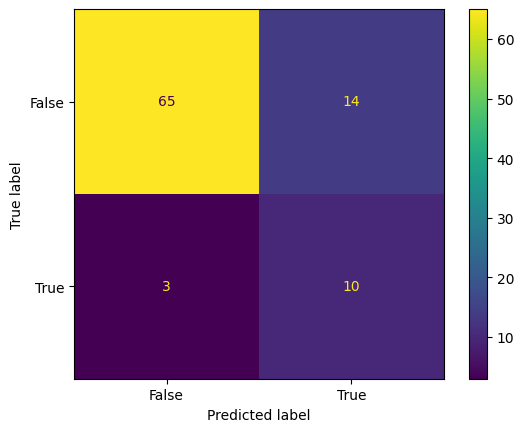

In [189]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## KNN

In [190]:
knn = sk.neighbors.KNeighborsClassifier(
    n_neighbors=50,
    weights='distance',
    algorithm='ball_tree',
    leaf_size=1,
    n_jobs=-1
    )

knn.fit(x_train_fitted_smote, y_train_smote)
y_pred = knn.predict(X_test)
print(sk.metrics.accuracy_score(y_test, y_pred))
print("Recall: ",sk.metrics.recall_score(y_test, y_pred))
print("Precision: ", sk.metrics.precision_score(y_test, y_pred))
print("AUROC: ", sk.metrics.roc_auc_score(y_test, y_pred))

0.8695652173913043
Recall:  0.07692307692307693
Precision:  1.0
AUROC:  0.5384615384615384


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



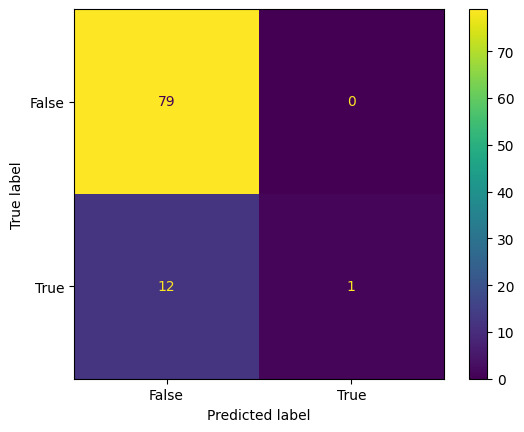

In [191]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



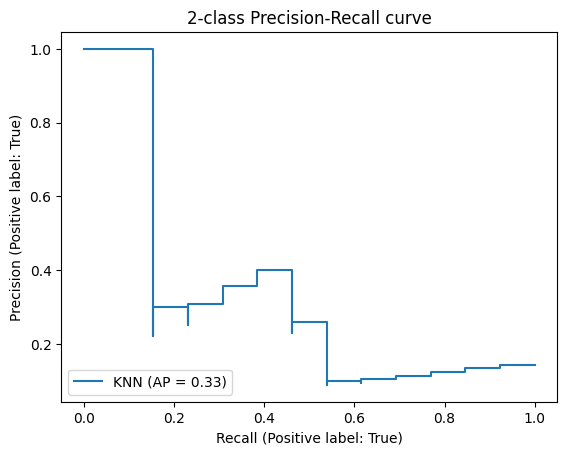

In [192]:
display = PrecisionRecallDisplay.from_estimator(
    knn, X_test, y_test, name="KNN"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Random Forest

In [193]:
from numpy import mean
from numpy import std
from numpy import arange

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

X_train_comp = joined_df[selected_features]
y_train_comp = joined_df[target]

oversample = SMOTE(random_state=1234)
X_train_smote_comp, y_train_smote_comp = oversample.fit_resample(X_train_comp, y_train_comp)

def get_models():
	models = dict()
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		# explore number of features
		for i in range(1,len(selected_features) + 1):
			# explore ratios from 10% to 100% in 10% increments
			for j in arange(0.1, 1.1, 0.1):
				key = str(n) + ' ' + str(i) + ' ' + ('%.1f' % j)
				# set max_samples=None to use 100%
				if j == 1.0:
					j = None
				models[key] = RandomForestClassifier(max_samples=j, max_features=i, n_estimators=n, random_state=5000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
recall_results = {}
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_smote_comp, y_train_smote_comp)
	# store the results
	recall_results[name] = mean(scores)

# Hyperparameter tuning
best_model = max(recall_results, key=recall_results.get)
print(best_model, recall_results[best_model])

1000 1 1.0 0.9787749287749287


In [196]:
# Prev cell results
# n_estimators max_features max_samples
# 1000 1 1.0

# RF works best with no tuning

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=5000)

rf.fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)

print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Recall:  0.7692307692307693
Precision:  0.45454545454545453
AUROC:  0.808666017526777
Accuracy:  0.8369565217391305


# Competition

## Prepare competition data

### Load

In [118]:
trans_comp_df = pd.read_csv('.\\ficheiros_competicao_dev\\trans_comp.csv', sep=';', low_memory=False)

loan_comp_df = pd.read_csv('.\\ficheiros_competicao_dev\\loan_comp.csv', sep=';', low_memory=False)

card_comp_df = pd.read_csv('.\\ficheiros_competicao_dev\\card_comp.csv', sep=';', low_memory=False)

### Treat data

In [119]:
trans_comp_df['operation'].fillna('N/A', inplace=True)
trans_comp_df['k_symbol'] = trans_comp_df['k_symbol'].apply(remove_empty_values_k_symbol)
trans_comp_df['bank'].fillna('Unknown', inplace=True)
trans_comp_df['account'].fillna(0, inplace=True)

In [120]:
trans_comp_df['trans_date'] = pd.to_datetime(trans_comp_df['date'].apply(get_formatted_date), infer_datetime_format=True)

trans_comp_df = trans_comp_df.drop(columns=['date'])

loan_comp_df['date'] = pd.to_datetime(loan_comp_df['date'].apply(get_formatted_date), infer_datetime_format=True)

card_comp_df['issued'] = pd.to_datetime(card_comp_df['issued'].apply(get_formatted_date), infer_datetime_format=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\2241467942.py:5: UserWarning:

Parsing '14/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\2241467942.py:5: UserWarning:

Parsing '17/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\2241467942.py:5: UserWarning:

Parsing '19/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\2241467942.py:5: UserWarning:

Parsing '20/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\2241467942.py:5: UserWarning:

Parsing '21/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent 

### Join Data

#### Account and Disposition

In [121]:
comp_df = account_df.merge(disp_df, on='account_id', how='inner', suffixes=['', '_disp'])

comp_df.rename(columns={
    'type': 'account_type',
    'frequency': 'issuance_freq'
}, inplace=True)

# Determine if account is shared or not
owner_number_account = comp_df['account_id'].value_counts()

comp_df['shared'] = comp_df.apply(lambda row: 1 if owner_number_account[row['account_id']] > 1 else 0, axis=1)

# Drop rows with disponents so there are no duplicated account rows
comp_df.drop(comp_df[comp_df['account_type'] == 'DISPONENT'].index, inplace=True)

# Drop account_type and disp_id column
comp_df.drop(columns=['account_type'], inplace=True)

comp_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,client_id,shared
0,576,55,monthly issuance,1993-01-01,692,692,1
2,3818,74,monthly issuance,1993-01-01,4601,4601,1
4,704,55,monthly issuance,1993-01-01,844,844,1
6,2378,16,monthly issuance,1993-01-01,2873,2873,0
7,2632,24,monthly issuance,1993-02-01,3177,3177,0


##### Competition and Clients

In [122]:
comp_df = comp_df.merge(client_df, on='client_id', how='left', suffixes=['', '_client'])

comp_df.drop(columns=['client_id'], inplace=True)

comp_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,shared,district_id_client,birthday,sex
0,576,55,monthly issuance,1993-01-01,692,1,74,1936-01-11,F
1,3818,74,monthly issuance,1993-01-01,4601,1,1,1935-04-02,M
2,704,55,monthly issuance,1993-01-01,844,1,22,1945-01-14,M
3,2378,16,monthly issuance,1993-01-01,2873,0,16,1975-03-24,F
4,2632,24,monthly issuance,1993-02-01,3177,0,24,1938-08-12,M


#### Competition and District

In [123]:
comp_df = comp_df.merge(district_df, left_on='district_id_client', right_on='code', how='inner', suffixes=['', '_district'])

comp_df.rename(columns={
    'code': 'district_code',
    'name': 'district_name'
}, inplace=True)

comp_df.drop(columns=['district_id', 'district_id_client'], inplace=True)

comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,576,monthly issuance,1993-01-01,692,1,1936-01-11,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
1,2484,monthly issuance,1993-03-01,2999,0,1979-03-24,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
2,1338,monthly issuance,1993-11-01,1619,1,1942-01-27,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
3,1179,monthly issuance,1993-01-23,1419,1,1918-01-25,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
4,1649,monthly issuance,1993-01-26,1999,0,1982-02-10,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347


#### Competition and Loan

In [124]:
comp_df = comp_df.merge(loan_comp_df, on='account_id', how='right', suffixes=['', '_loan'])

comp_df.rename(columns={
    'date': 'loan_date'
}, inplace=True)

# Add seasons
comp_df['season_on_loan'] = comp_df['loan_date'].apply(get_season_from_Date)
comp_df['loan_year'] = joined_df['loan_date'].apply(get_year_from_date)

comp_df.head(100)

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of commited crimes '95,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,loan_year
0,4473,monthly issuance,1995-09-10,5395,0,1962-06-01,M,45,Jicin,east Bohemia,...,2080.0,2122,5895,1997-03-01,93960,60,1566,NaN,winter,1993.0
1,10365,monthly issuance,1995-02-09,12448,0,1949-01-21,F,22,Domazlice,west Bohemia,...,1089.0,1117,7122,1997-04-01,260640,36,7240,NaN,spring,1993.0
2,5724,issuance after transaction,1995-04-19,6922,0,1939-04-27,F,14,Ceske Budejovice,south Bohemia,...,6604.0,6295,6173,1997-08-01,232560,48,4845,NaN,summer,1993.0
3,5591,monthly issuance,1996-03-16,6749,1,1943-09-29,F,9,Nymburk,central Bohemia,...,2987.0,2487,6142,1997-01-21,221880,60,3698,NaN,spring,1993.0
4,2018,monthly issuance,1995-04-06,2451,0,1939-12-06,M,42,Havlickuv Brod,east Bohemia,...,1658.0,1668,5358,1997-01-21,38520,12,3210,NaN,spring,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,442,monthly issuance,1997-03-30,533,0,1941-05-19,F,54,Brno - mesto,south Moravia,...,18721.0,18696,5063,1997-10-07,357840,48,7455,NaN,autumn,1994.0
96,319,weekly issuance,1995-10-17,389,0,1974-06-30,F,47,Pardubice,east Bohemia,...,6079.0,5410,5041,1997-11-07,369000,60,6150,NaN,autumn,1994.0
97,525,monthly issuance,1996-03-20,631,0,1956-03-22,F,70,Karvina,north Moravia,...,9878.0,10108,5086,1997-07-16,210384,48,4383,NaN,summer,1994.0
98,9513,monthly issuance,1996-12-05,11405,1,1951-04-11,F,59,Kromeriz,south Moravia,...,2595.0,2305,6942,1997-07-16,18324,12,1527,NaN,summer,1994.0


In [125]:
comp_df['age_on_loan_request'] = comp_df.apply(lambda row: (row['loan_date'] - row['birthday'])/np.timedelta64(1, 'Y'), axis=1)

comp_df.drop(columns=['birthday'], inplace=True)

comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,loan_year,age_on_loan_request
0,4473,monthly issuance,1995-09-10,5395,0,M,45,Jicin,east Bohemia,77917,...,2122,5895,1997-03-01,93960,60,1566,NaN,winter,1993.0,34.749516
1,10365,monthly issuance,1995-02-09,12448,0,F,22,Domazlice,west Bohemia,58400,...,1117,7122,1997-04-01,260640,36,7240,NaN,spring,1993.0,48.192639
2,5724,issuance after transaction,1995-04-19,6922,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6295,6173,1997-08-01,232560,48,4845,NaN,summer,1993.0,58.265399
3,5591,monthly issuance,1996-03-16,6749,1,F,9,Nymburk,central Bohemia,81344,...,2487,6142,1997-01-21,221880,60,3698,NaN,spring,1993.0,53.315263
4,2018,monthly issuance,1995-04-06,2451,0,M,42,Havlickuv Brod,east Bohemia,95907,...,1668,5358,1997-01-21,38520,12,3210,NaN,spring,NaN,57.129168


In [126]:
card_disp_df = card_comp_df.merge(disp_df, on='disp_id', how='inner', suffixes=['_card', '_disp'])

cards_per_user_df = card_disp_df.groupby(['account_id', 'type_card']).size().unstack(fill_value=0)

comp_df = comp_df.merge(cards_per_user_df, on='account_id', how='left', suffixes=['', ''])

comp_df.fillna(0, inplace=True)

comp_df['card_score'] = (comp_df['junior'] + comp_df['classic'] * 3 + comp_df['gold'] * 10).astype(int)

comp_df.drop(columns=['junior', 'classic', 'gold'], inplace=True)

comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,loan_id,loan_date,amount,duration,payments,status,season_on_loan,loan_year,age_on_loan_request,card_score
0,4473,monthly issuance,1995-09-10,5395,0,M,45,Jicin,east Bohemia,77917,...,5895,1997-03-01,93960,60,1566,0.0,winter,1993.0,34.749516,0
1,10365,monthly issuance,1995-02-09,12448,0,F,22,Domazlice,west Bohemia,58400,...,7122,1997-04-01,260640,36,7240,0.0,spring,1993.0,48.192639,0
2,5724,issuance after transaction,1995-04-19,6922,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6173,1997-08-01,232560,48,4845,0.0,summer,1993.0,58.265399,0
3,5591,monthly issuance,1996-03-16,6749,1,F,9,Nymburk,central Bohemia,81344,...,6142,1997-01-21,221880,60,3698,0.0,spring,1993.0,53.315263,0
4,2018,monthly issuance,1995-04-06,2451,0,M,42,Havlickuv Brod,east Bohemia,95907,...,5358,1997-01-21,38520,12,3210,0.0,spring,0.0,57.129168,0


#### Competition and Transactions

In [127]:
from dateutil.relativedelta import relativedelta

account_balance_df = trans_comp_df[['account_id', 'balance', 'trans_date']]

comp_df[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']] = comp_df.apply(find_balance_at_date, axis=1)
comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,duration,payments,status,season_on_loan,loan_year,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before
0,4473,monthly issuance,1995-09-10,5395,0,M,45,Jicin,east Bohemia,77917,...,60,1566,0.0,winter,1993.0,34.749516,0,49548.5,55140.2,62781.0
1,10365,monthly issuance,1995-02-09,12448,0,F,22,Domazlice,west Bohemia,58400,...,36,7240,0.0,spring,1993.0,48.192639,0,11565.4,11565.4,43647.9
2,5724,issuance after transaction,1995-04-19,6922,0,F,14,Ceske Budejovice,south Bohemia,177686,...,48,4845,0.0,summer,1993.0,58.265399,0,45754.0,45754.0,45754.0
3,5591,monthly issuance,1996-03-16,6749,1,F,9,Nymburk,central Bohemia,81344,...,60,3698,0.0,spring,1993.0,53.315263,0,38913.4,41862.4,55110.1
4,2018,monthly issuance,1995-04-06,2451,0,M,42,Havlickuv Brod,east Bohemia,95907,...,12,3210,0.0,spring,0.0,57.129168,0,18914.3,24559.0,22351.0


In [128]:
grouped = trans_comp_df.groupby("account_id")
account_balance_df = trans_comp_df[['account_id', 'k_symbol', 'amount']]

interst_mean_df = pd.DataFrame(columns=["account_id", "interest_mean"])


for acc_id, group in grouped:
    interst_mean = abs(group[group["k_symbol"] == "interest credited"]["amount"].mean())
    interst_mean_df = interst_mean_df.append({"account_id": int(acc_id), "interest_mean": interst_mean}, ignore_index=True)

comp_df["interest_mean"] = interst_mean_df["interest_mean"]
comp_df["interest_mean"].fillna(0.0, inplace=True)

joined_df.head()

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\3163711840.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\3163711840.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\3163711840.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\3163711840.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\andre\AppData\Local\Temp\ipykernel_24892\3163711840.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

,issuance_freq,acc_creation_date,shared,sex,district_code,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,...,loan_year,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before,interest_mean,balance_below_5k,loan_amount_over_balance,loan_over_100k,age_bracket
0,2,1993-03-22,False,0,30,7,94812,15,13,8,...,1993,0,11000.0,0.0,0.0,74.814286,1,8.763273,False,3
1,1,1993-02-13,False,1,46,2,112709,48,20,7,...,1993,0,52208.9,52208.9,106447.2,128.930000,2,3.178768,True,1
2,1,1993-08-02,False,1,45,2,77917,85,19,6,...,1993,0,20272.8,27619.5,0.0,98.416667,1,6.268498,True,4
3,1,1993-01-30,False,0,14,5,177686,69,27,10,...,1993,0,40164.0,0.0,0.0,122.782609,1,2.634299,True,3
6,1,1993-01-14,False,1,15,5,58796,22,16,7,...,1993,0,21029.0,24136.1,25279.8,109.802128,1,2.510248,False,0


In [129]:
def get_balance_below_5k_comp(joined_df_row):
    # Get all balance information for account
    account_balances = trans_comp_df[['account_id', 'balance', 'trans_date']][account_balance_df['account_id'] == joined_df_row['account_id']]

    if (account_balances.empty):
        joined_df_row['balance_below_5k'] = 0

        return joined_df_row[['balance_below_5k']]
    
    # Get balance at loan date
    account_balances_below_5k = account_balances.copy()

    account_balances_below_5k = account_balances_below_5k[account_balances_below_5k['balance'] < 5000]

    joined_df_row['balance_below_5k'] = account_balances_below_5k['balance'].count()

    return joined_df_row[['balance_below_5k']]

In [130]:
comp_df[['balance_below_5k']] = comp_df.apply(get_balance_below_5k_comp, axis=1)

In [131]:
comp_df['loan_amount_over_balance'] = comp_df.apply(get_loan_amount_over_balance, axis=1)

#### Get age bracket

In [132]:
comp_df['age_bracket'] = comp_df['age_on_loan_request'].apply(get_age_bracket)

#### Set correct data types

In [133]:
comp_df['shared'] = comp_df['shared'].astype('bool')


In [134]:
comp_df.drop(columns=['district_name', 'account_id', 'disp_id', 'age_on_loan_request'], inplace=True)

In [135]:
cat = ['sex', 'region', 'issuance_freq', 'season_on_loan', 'age_bracket']

comp_df[cat] = comp_df[cat].astype('category')

comp_df[cat] = comp_df[cat].apply(lambda x : x.cat.codes)

In [136]:
from sklearn.svm import SVC
from sklearn.metrics import PrecisionRecallDisplay

X_train_comp = joined_df[selected_features]
y_train_comp = joined_df[target]

oversample = SMOTE(random_state=1234)
X_train_smote_comp, y_train_smote_comp = oversample.fit_resample(X_train_comp, y_train_comp)

lsvc = SVC(verbose=0, C=0.5, kernel='rbf', probability=True, random_state=42)

lsvc.fit(X_train_smote_comp, y_train_smote_comp)

score = lsvc.score(X_train_smote, y_train_smote)

In [137]:

rf = RandomForestClassifier(n_estimators=1000, max_features=4, max_samples=1.0)

rf.fit(X_train_smote_comp, y_train_smote_comp)

RandomForestClassifier(max_features=4, max_samples=1.0, n_estimators=1000)

In [138]:
# knn = sk.neighbors.KNeighborsClassifier(
#     n_neighbors=50,
#     weights='distance',
#     algorithm='ball_tree',
#     leaf_size=1,
#     n_jobs=-1
#     )

# knn.fit(X_train_smote_comp, y_train_smote_comp)

In [139]:
X_test_comp = comp_df[selected_features]

In [140]:

y_pred = rf.predict_proba(X_test_comp)
# print("Recall: ",sk.metrics.recall_score(y_test, y_pred))

In [141]:
res_df = pd.DataFrame(columns=['Id', 'Predicted'])

res_df['Id'] = comp_df['loan_id'].copy()

res_df['Predicted'] = y_pred[:, 1]


In [142]:
res_df.to_csv('res.csv', sep=',', index=False, )